In [1]:
import uproot
from coffea.nanoevents import NanoEventsFactory,BaseSchema
import coffea.lookup_tools
import hist
import matplotlib.pyplot as plt
import mplhep as hep
hep.style.use("CMS")
import numpy as np
import awkward as ak
import glob

In [2]:
dirname = "/nfs/dust/cms/user/albrechs/UHH2/JetMassOutput/vjetsTrees/workdir_vjets_UL17/"
fname_pattern = "*WJetsToQQ*.root"

In [3]:
tree_name = 'AnalysisTree'
tree_paths = [f"{fpath}:{tree_name}" for fpath in glob.glob(dirname+fname_pattern)]

In [4]:
filter_ = lambda x: x in ['pt','mjet','pt_gen_ak8','msd_gen_ak8','jecfactor','weight','N2','IsMergedWZ', 'trigger_bits']
events = uproot.concatenate(tree_paths, filter_name = filter_)

In [34]:
events['pt_raw'] = events.pt
events['pt'] = events.pt_raw*events.jecfactor
events['ptgen'] = events.pt_gen_ak8
events['mjet_raw'] = events.mjet
events['mjet'] = events.mjet_raw*events.jecfactor
events['mjetgen'] = events.msd_gen_ak8
events['rho'] = 2*np.log(events.mjet/events.pt)
events['rhogen'] = 2*np.log(events.mjetgen/events.ptgen)




/nfs/dust/cms/user/albrechs/miniconda3/envs/coffea/lib/python3.7/site-packages/awkward/_connect/_numpy.py:210: RuntimeWarning: divide by zero encountered in log
  *[nplike.asarray(x) for x in inputs], **kwargs
/nfs/dust/cms/user/albrechs/miniconda3/envs/coffea/lib/python3.7/site-packages/awkward/_connect/_numpy.py:210: RuntimeWarning: invalid value encountered in log
  *[nplike.asarray(x) for x in inputs], **kwargs


In [6]:

ddtmaps_path = '/afs/desy.de/user/a/albrechs/xxl/af-cms/UHH2/10_6_28/CMSSW_10_6_28/src/UHH2/JetMass/Histograms/ddtmaps.npy'
n2ddtmap = np.load(ddtmaps_path,allow_pickle=True).item()
year = 'UL17'
corrected_str = '_corrected_pt_mass'

n2ddt_LOT = coffea.lookup_tools.dense_lookup.dense_lookup(
                n2ddtmap[f'n2ddt_map_{year}_smooth_4_0p05{corrected_str}'][0],
                dims = (n2ddtmap[f'n2ddt_map_{year}_smooth_4_0p05{corrected_str}'][1],
                        n2ddtmap[f'n2ddt_map_{year}_smooth_4_0p05{corrected_str}'][2]))


In [7]:
lumi = 41.47968052876168 # fb^-1

In [8]:
def cms_label(ax,fs=20):
    hep.cms.label(label=', Work in Progress',year=2017,ax=ax,fontsize=fs)
def fax(w=9,h=9):
    return plt.subplots(figsize=(w,h))
    
    
stability_color = '#1b9e77'
purity_color = '#d95f02'


In [41]:
n2ddt = lambda e : ( e.N2 - n2ddt_LOT(e.rho, e.pt) ) > 0

events_sel = events[
    (events.rho > -6.0)
    & (events.rho < -2.1)
    #&(events.rhogen > -6.0)
    #& (events.rhogen < -2.1)
    &(n2ddt(events))
    & (events.IsMergedWZ==1)
    & (events.ptgen>500)
    #& (events.pt_corr >500)
    #& (events.trigger_bits[:,7]==1)
]

In [45]:
sel_events_tree_fname = '/nfs/dust/cms/user/albrechs/wjetstoqq_selected.parquet'
ak.to_parquet(events_sel,sel_events_tree_fname)

In [46]:
events_sel = ak.from_parquet(sel_events_tree_fname)

In [10]:
def build_migration_matrix(reco_bins,gen_bins,reco_val,gen_val,weights):
    h_pt = hist.Hist(
        #hist.axis.Variable(pt_reco_bins,name='pt_reco',overflow=True),
        #hist.axis.Variable(pt_gen_bins,name='pt_gen',overflow=True),
        #hist.axis.Regular(100,500,1200,name='pt_reco',overflow=True),
        #hist.axis.Regular(100,500,1200,name='pt_gen',overflow=True),
        reco_bins,
        gen_bins,
        storage=hist.storage.Weight()
    )
    h_pt.fill(
        **{
            reco_bins.name:reco_val,
            gen_bins.name:gen_val,
            'weight':weights
        }
    )
    return h_pt


# Binning Optimization

starting with fine binning, let's scan each dim and merge bins until stability and purity are above some threshold

In [11]:
threshold = 0.5
threshold_str = str(threshold).replace(".","p")

initial_pt_binning = np.arange(500,1500,5)
#initial_pt_binning = np.array([550, 650, 800, 1200])
initial_mjet_binning = np.arange(30,300,0.5)

pt_gen_binning = np.array([0,550, 650, 800, 1200,np.inf])


In [26]:
def migration_metric(h,axis_name='pt_reco',flow=False):
    axes = [a.name for a in h.axes]
    if(axis_name not in axes):
        raise NameError(f"Did not find {axis_name} among axes of hist!")
    axis_index = axes.index(axis_name)
    mat = h.to_numpy(flow=flow)[0]
    if(axis_index != 0):
        mat = mat.T
    metric_bin_contents = []
    #metric_bin_edges = h.axes[axis_index].edges
    metric_bin_edges = h.to_numpy(flow=flow)[axis_index+1]
    other_dim_edges = h.to_numpy(flow=flow)[(1-axis_index)+1]
    main_dim_max_bin = len(metric_bin_edges)-1-(2 if flow else 0) #-1 for last edge and -2 for uflow oflow
    second_dim_max_bin = (len(other_dim_edges)-1-(2 if flow else 0))

    renormed_mat = mat/np.sum(mat,axis=1)[:,None]
        
    for bin_ind in range(main_dim_max_bin):
        bin_ind_x = bin_ind
        bin_ind_y = bin_ind
        if flow:
            bin_ind_x = bin_ind+1
            bin_ind_y = min(bin_ind+1, second_dim_max_bin+1) # set to overflow of secondary dim if bin_ind exceeds
            if(bin_ind_y != bin_ind+1):
                print('Warning! reached end of binning in secondary dimension! taking counts from overflow for renorm')
        metric_bin_contents.append(renormed_mat[bin_ind_x,bin_ind_y])
    return (np.array(metric_bin_contents),metric_bin_edges[1:-1] if flow else metric_bin_edges) # return calculated metric and bin edges without flow

## First look at $p_T$ binning metrics

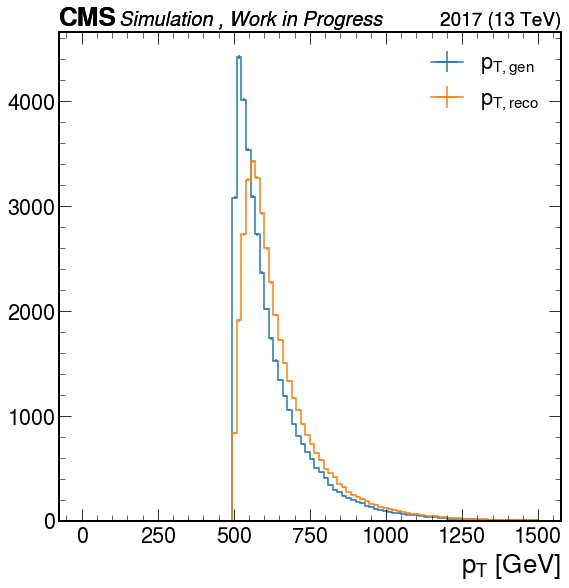

In [12]:
h_pt_test = build_migration_matrix(
    hist.axis.Regular(100,0,1500,name='pt_reco',overflow=True),
    hist.axis.Regular(100,0,1500,name='pt_gen',overflow=True),
    events_sel.pt,
    events_sel.ptgen,
    events_sel.weight
)
#f,ax=plt.subplots()
f,ax = fax()
hep.histplot(h_pt_test[::sum,:],ax=ax,label=r'$p_{T,\mathrm{gen}}$')
hep.histplot(h_pt_test[:,::sum],ax=ax,label=r'$p_{T,\mathrm{reco}}$')
#ax.set_xlim(500,1200)
cms_label(ax)
hep.cms.label(label=', Work in Progress',year=2017,ax=ax,fontsize=20)
ax.legend()
ax.set_xlabel(r'$p_{T}~$[GeV]')
f.savefig('unfolding_binning_plots/pt_initial_binning.pdf',bbox_inches='tight',transparent=True)


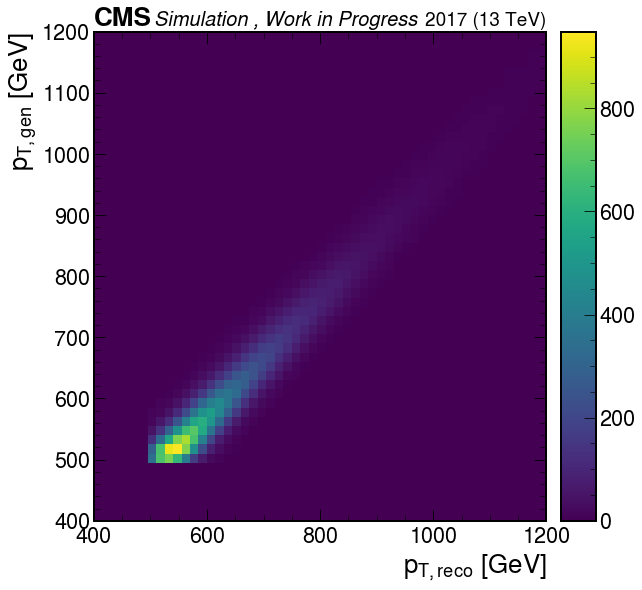

In [13]:
f,ax = fax()
hep.hist2dplot(h_pt_test.to_numpy(),ax=ax)
cms_label(ax)
ax.set_xlabel(r'$p_{T,\mathrm{reco}}~$[GeV]')
ax.set_ylabel(r'$p_{T,\mathrm{gen}}~$[GeV]')
ax.set_xlim(400,1200)
ax.set_ylim(400,1200)
f.savefig('unfolding_binning_plots/pt_2d_initial_binning.pdf',bbox_inches='tight',transparent=True)


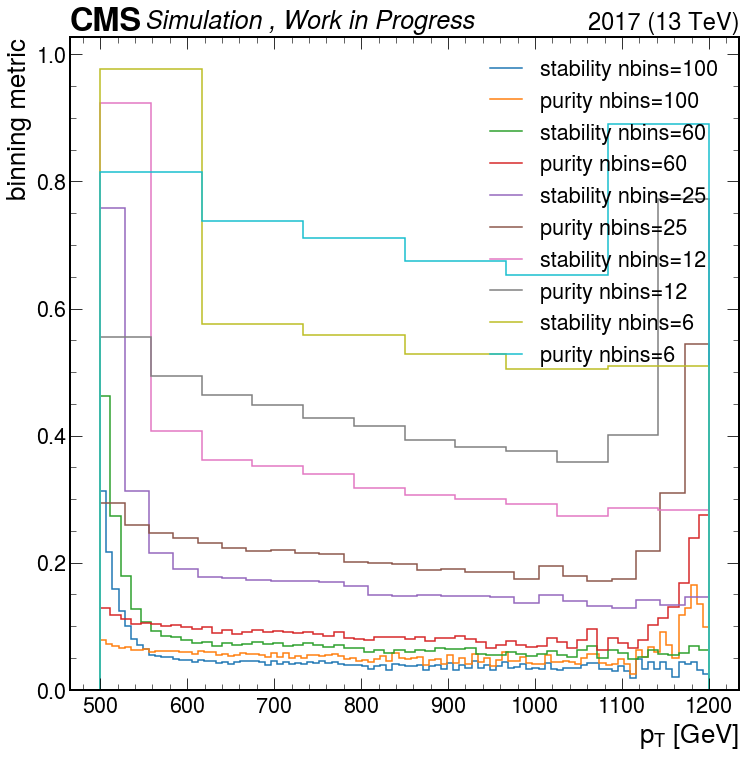

In [16]:
def plot_metrics(n,ax):
    h = build_migration_matrix(
        hist.axis.Regular(n,500,1200,name='pt_reco',overflow=True),
        hist.axis.Regular(n,500,1200,name='pt_gen',overflow=True),
        events_sel.pt,
        events_sel.ptgen,
        events_sel.weight
    )
    flow = False
    hep.histplot(migration_metric(h,'pt_reco',flow=flow),label=f'stability nbins={n}',ax=ax)#,**{'color':'green'})
    hep.histplot(migration_metric(h,'pt_gen',flow=flow),label=f'purity nbins={n}',ax=ax)#,**{'color':'red'})

    
#f,ax = plt.subplots()
f,ax = fax(12,12)
for n in [100,60,25,12,6]:
    plot_metrics(n,ax)

ax.legend()
cms_label(ax,fs=25)
ax.set_xlabel(r'$p_T~$[GeV]')
ax.set_ylabel(r'binning metric')

f.savefig('unfolding_binning_plots/pt_equidistant_binnings_metrics.pdf',bbox_inches='tight',transparent=True)


## bin optimization methods

In [12]:

def create_new_binning_(binning, threshold = 0.4, flow=False, variable='pt',e = events_sel,reco_corr_factors=1.0):
    migmat = build_migration_matrix(
        hist.axis.Variable(binning,name=f'{variable}_reco',overflow=flow),
        hist.axis.Variable(binning,name=f'{variable}_gen',overflow=flow),
        e[f'{variable}']*reco_corr_factors,
        e[f'{variable}gen'],
        e['weight'],
    )
    
    stability = migration_metric(migmat,f'{variable}_reco',flow=flow)[0]
    purity = migration_metric(migmat,f'{variable}_gen',flow=flow)[0]
    

    for bin_ind in range(len(binning)-1):
        if(purity[bin_ind] < threshold or stability[bin_ind] < threshold):            
            return np.delete(binning,bin_ind+1) if bin_ind < len(binning)-2 else binning
    return binning

create_new_binning = lambda x:create_new_binning_(**x)
        

In [13]:
def create_new_binning_bidirectional_(binning,threshold=0.4,flow=False,variable='mjet',e=events_sel, split_value=80.,reco_corr_factors=1.0):
    migmat = build_migration_matrix(
        hist.axis.Variable(binning,name=f'{variable}_reco',overflow=flow),
        hist.axis.Variable(binning,name=f'{variable}_gen',overflow=flow),
        e[f'{variable}']*reco_corr_factors,
        e[f'{variable}gen'],
        e['weight'],
    )
    
    stability = migration_metric(migmat,f'{variable}_reco',flow=flow)[0]
    purity = migration_metric(migmat,f'{variable}_gen',flow=flow)[0]
    split_bin = np.abs(binning-split_value).argmin()
    
    for bin_ind in reversed(range(split_bin+1)):
        if((purity[bin_ind-1] < threshold or stability[bin_ind-1] < threshold) and bin_ind > 1):
            #print(f'removing bin_edge {binning[bin_ind-1]} since in above bin: stability={stability[bin_ind]} and purity={purity[bin_ind]}')
            #print(f'neighboring bins: stability={stability[bin_ind-1]} {stability[bin_ind+1]} and purity={purity[bin_ind-1]} {purity[bin_ind+1]}')
            return np.delete(binning,bin_ind-1)# if bin_ind == 0 else binning
    for bin_ind in range(split_bin,len(binning)-1):
        if( (purity[bin_ind] < threshold or stability[bin_ind] < threshold) and bin_ind < len(binning)-2):
            return np.delete(binning,bin_ind+1)# if bin_ind < len(binning)-2 else binning
    return binning


create_new_binning_bidirectional = lambda x: create_new_binning_bidirectional_(**x,split_value=85.)

In [14]:
def optimize_binning(initial_binning, threshold,variable = 'pt',flow = False,update_binning=create_new_binning):
    binning = initial_binning#np.arange(500,1500,5)
    #print(binning)
    counter = 0
    while counter<1000:
        counter += 1
        n_old_bins = len(binning)
        binning = update_binning({'binning':binning,'threshold':threshold,'flow':flow,'variable':variable})
        n_new_bins = len(binning)
        if(counter % 50 == 0 ):
            print(n_old_bins, '->',n_new_bins)
            #print(binning)
        if( n_old_bins == n_new_bins ):
            break
    print('Final binning:',binning)
    print('bin widths:',(binning[1:]-binning[:-1]))
    return binning



In [15]:
def reco_binning(gen_edges):
    """For now just return binning finer by a factor of 2, i.e. split every bin in half"""
    gen_edges_ = gen_edges[:-1] if gen_edges[-1]==np.inf else gen_edges
    reco_edges=np.concatenate((gen_edges_,(gen_edges_[:-1]+gen_edges_[1:])/2))
    if gen_edges[-1] == np.inf:
        reco_edges=np.concatenate((reco_edges,np.array([np.inf])))
    reco_edges.sort()
    return reco_edges

## $p_T$ binning optimization

In [39]:
final_pt_gen_binning = optimize_binning(
    initial_pt_binning,
    threshold=threshold,
    variable='pt'
)

final_pt_reco_binning=reco_binning(final_pt_gen_binning)

151 -> 150
101 -> 100
51 -> 50
Final binning: [ 500  555  635  725  825  935 1050 1170 1315 1460 1495]
bin widths: [ 55  80  90 100 110 115 120 145 145  35]


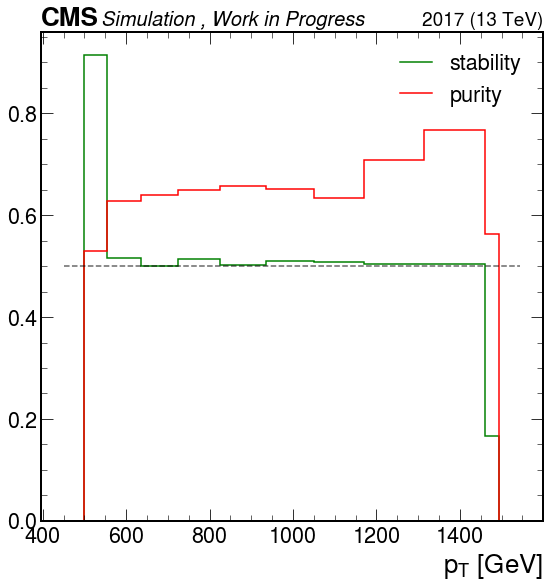

In [23]:
f,ax = fax()
flow = False
migmat = build_migration_matrix(
    hist.axis.Variable(final_pt_gen_binning,name='pt_reco',overflow=flow),
    hist.axis.Variable(final_pt_gen_binning,name='pt_gen',overflow=flow),
    events_sel.pt,
    events_sel.ptgen,
    events_sel.weight
)
hep.histplot(migration_metric(migmat,'pt_reco',flow=flow),label=f'stability',ax=ax,**{'color':'green'})
hep.histplot(migration_metric(migmat,'pt_gen',flow=flow),label=f'purity',ax=ax,**{'color':'red'})
ax.plot(ax.get_xlim(),[threshold,threshold],'k--',alpha=0.6)

ax.legend()
ax.set_xlabel(r'$p_T~$[GeV]')
cms_label(ax)
f.savefig(f'unfolding_binning_plots/pt_optimized_binning_{threshold_str}_metrics.pdf',bbox_inches='tight',transparent=True)


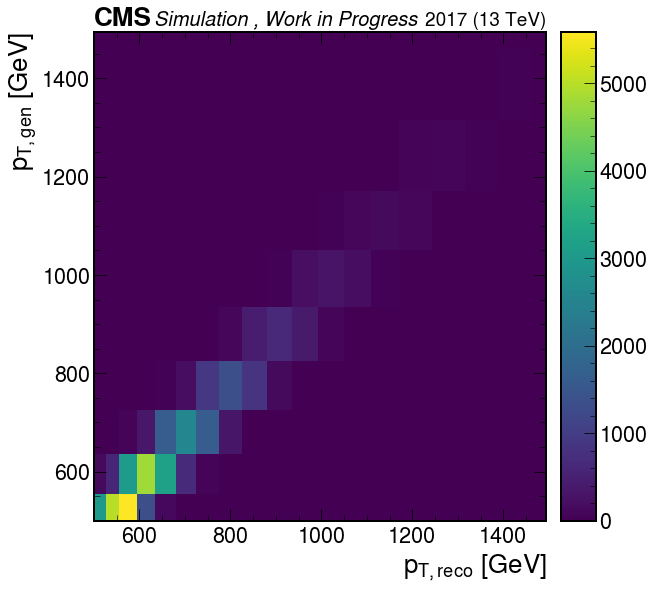

In [24]:
flow=True
migmat = build_migration_matrix(
    hist.axis.Variable(final_pt_reco_binning,name='pt_reco',overflow=flow),
    hist.axis.Variable(final_pt_gen_binning,name='pt_gen',overflow=flow),
    events_sel.pt,
    events_sel.ptgen,
    events_sel.weight
)

f,ax=fax()

hep.hist2dplot(migmat.to_numpy(),ax=ax)

cms_label(ax)
ax.set_xlabel(r'$p_{T,\mathrm{reco}}~$[GeV]')
ax.set_ylabel(r'$p_{T,\mathrm{gen}}~$[GeV]')
f.savefig(f'unfolding_binning_plots/pt_2d_optimized_binning_{threshold_str}.pdf',bbox_inches='tight',transparent=True)


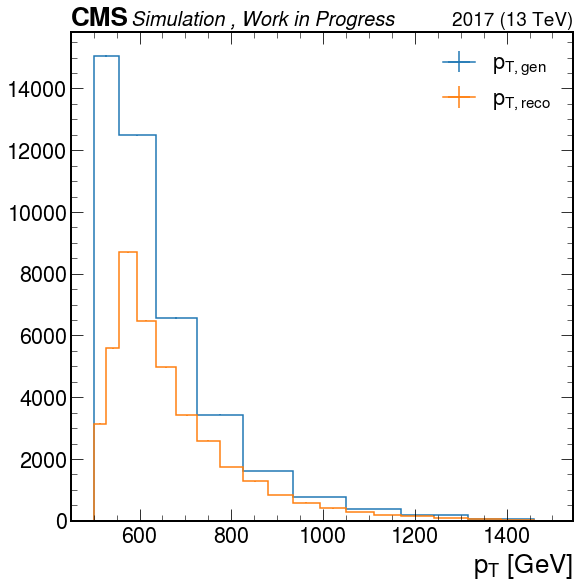

In [25]:
f,ax = fax()

hep.histplot(migmat[::sum,:],ax=ax,label=r'$p_{T,\mathrm{gen}}$')
hep.histplot(migmat[:,::sum],ax=ax,label=r'$p_{T,\mathrm{reco}}$')
ax.legend()

ax.set_xlabel(r'$p_T~$[GeV]')
cms_label(ax)
f.savefig(f'unfolding_binning_plots/pt_optimized_binning_{threshold_str}.pdf',bbox_inches='tight',transparent=True)


## First look at $m_{SD}$ binning metrics

repeating everything for mjet binning

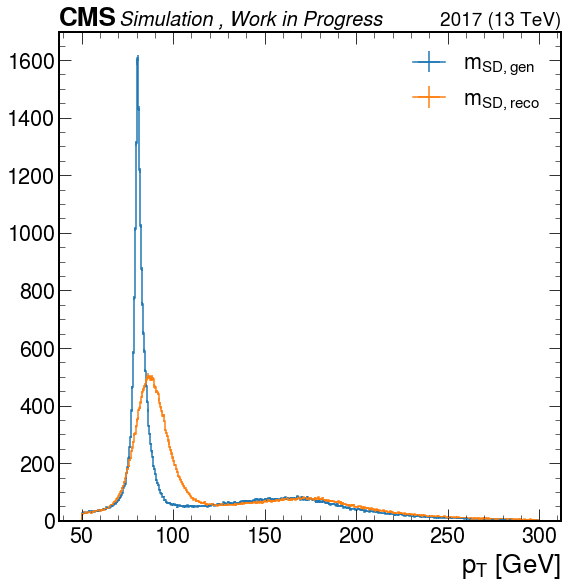

In [29]:
h_mjet_test = build_migration_matrix(
    hist.axis.Variable(initial_mjet_binning,name='mjet_reco',overflow=True),
    hist.axis.Variable(initial_mjet_binning,name='mjet_gen',overflow=True),
    events_sel.mjet,
    events_sel.mjetgen,
    events_sel.weight,
)
f,ax=fax()
hep.histplot(h_mjet_test[::sum,:],ax=ax,label=r'$m_{SD,\mathrm{gen}}$')
hep.histplot(h_mjet_test[:,::sum],ax=ax,label=r'$m_{SD,\mathrm{reco}}$')
ax.set_xlabel(r'$p_T~$[GeV]')
cms_label(ax)
ax.legend()

#ax.set_xlim(65,105)

f.savefig('unfolding_binning_plots/mjet_initial_binning.pdf',bbox_inches='tight',transparent=True)


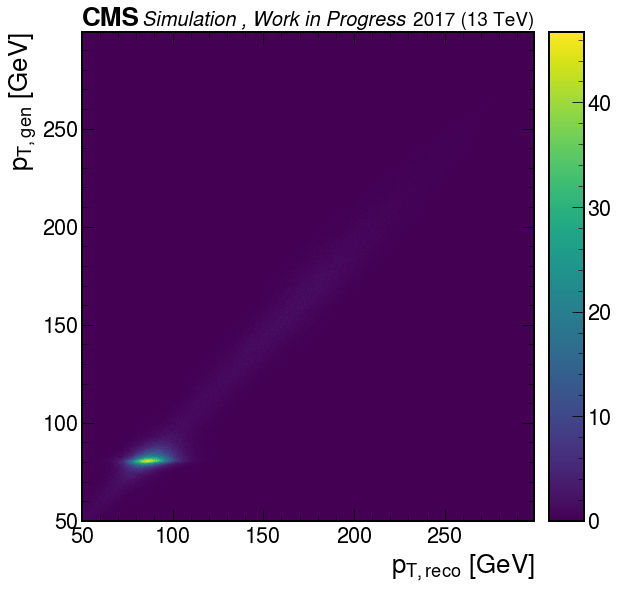

In [30]:
f,ax = fax()
hep.hist2dplot(h_mjet_test.to_numpy(flow=False),ax=ax)

cms_label(ax)
ax.set_xlabel(r'$p_{T,\mathrm{reco}}~$[GeV]')
ax.set_ylabel(r'$p_{T,\mathrm{gen}}~$[GeV]')
f.savefig('unfolding_binning_plots/mjet_2d_initial_binning.pdf',bbox_inches='tight',transparent=True)


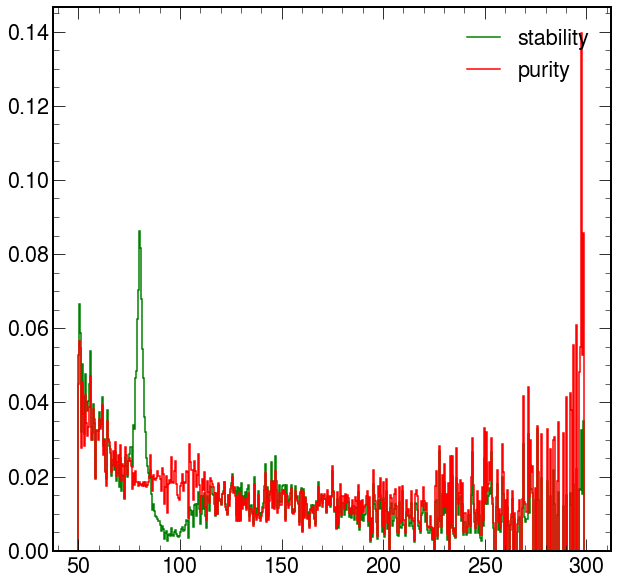

In [32]:
f,ax = plt.subplots()
flow = False
migmat = build_migration_matrix(
    hist.axis.Variable(initial_mjet_binning,name='mjet_reco',overflow=flow),
    hist.axis.Variable(initial_mjet_binning,name='mjet_gen',overflow=flow),
    events_sel.mjet,
    events_sel.mjetgen,
    events_sel.weight
)
hep.histplot(migration_metric(migmat,'mjet_reco',flow=flow),label=f'stability',ax=ax,**{'color':'green'})
hep.histplot(migration_metric(migmat,'mjet_gen',flow=flow),label=f'purity',ax=ax,**{'color':'red'})
ax.legend()


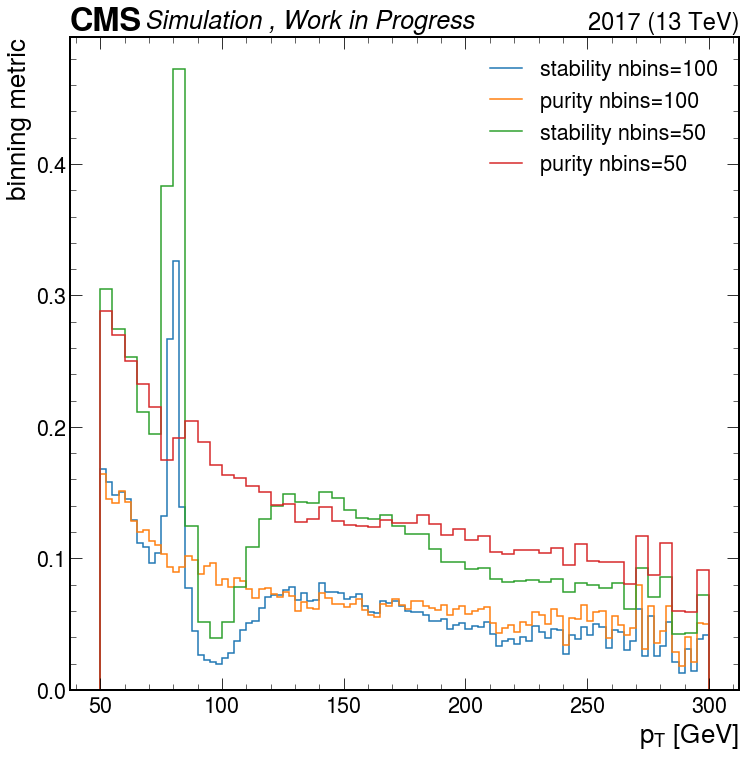

In [34]:
def plot_metrics(n,ax):
    h = build_migration_matrix(
        hist.axis.Regular(n,50,300,name='mjet_reco',overflow=True),
        hist.axis.Regular(n,50,300,name='mjet_gen',overflow=True),
        events_sel.mjet,
        events_sel.mjetgen,
        events_sel.weight
    )
    flow = True
    hep.histplot(migration_metric(h,'mjet_reco',flow=flow),label=f'stability nbins={n}',ax=ax)#,**{'color':'green'})
    hep.histplot(migration_metric(h,'mjet_gen',flow=flow),label=f'purity nbins={n}',ax=ax)#,**{'color':'red'})

    
f,ax = fax(12,12)

for n in [100,50]:#,60,25,12,6]:
    plot_metrics(n,ax)

ax.legend()

cms_label(ax,fs=25)
ax.set_xlabel(r'$p_T~$[GeV]')
ax.set_ylabel(r'binning metric')

f.savefig('unfolding_binning_plots/mjet_equidistant_binnings_metrics.pdf',bbox_inches='tight',transparent=True)


## First attempt on $m_{SD}$ binning optimization
here we start with merging bins in both directions starting from the peak position

In [36]:
final_mjet_gen_binning = optimize_binning(
    initial_mjet_binning,
    threshold=threshold,
    variable='mjet',
    update_binning=create_new_binning_bidirectional
)
final_mjet_reco_binning = reco_binning(final_mjet_gen_binning)

451 -> 450
401 -> 400
351 -> 350
301 -> 300
251 -> 250
201 -> 200
151 -> 150
101 -> 100
51 -> 50
Final binning: [ 50.   85.  163.  185.5 216.5 252.5 289.5 299.5]
bin widths: [35.  78.  22.5 31.  36.  37.  10. ]


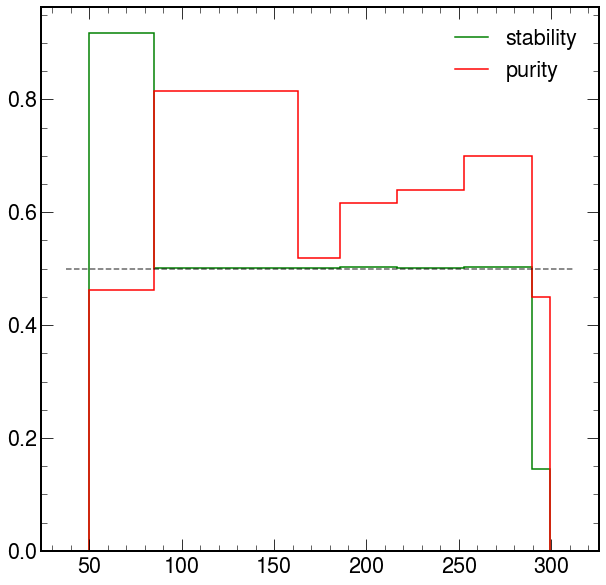

In [37]:
f,ax = plt.subplots()
flow = False
migmat = build_migration_matrix(
    hist.axis.Variable(final_mjet_gen_binning,name='mjet_reco',overflow=flow),
    hist.axis.Variable(final_mjet_gen_binning,name='mjet_gen',overflow=flow),
    events_sel.mjet,
    events_sel.mjetgen,
    events_sel.weight,
)
hep.histplot(migration_metric(migmat,'mjet_reco',flow=flow),label=f'stability',ax=ax,**{'color':'green'})
hep.histplot(migration_metric(migmat,'mjet_gen',flow=flow),label=f'purity',ax=ax,**{'color':'red'})
ax.legend()
ax.plot(ax.get_xlim(),[threshold,threshold],'k--',alpha=0.6)
f.savefig(f'unfolding_binning_plots/mjet_optimized_binning_{threshold_str}_metrics.pdf',bbox_inches='tight',transparent=True)


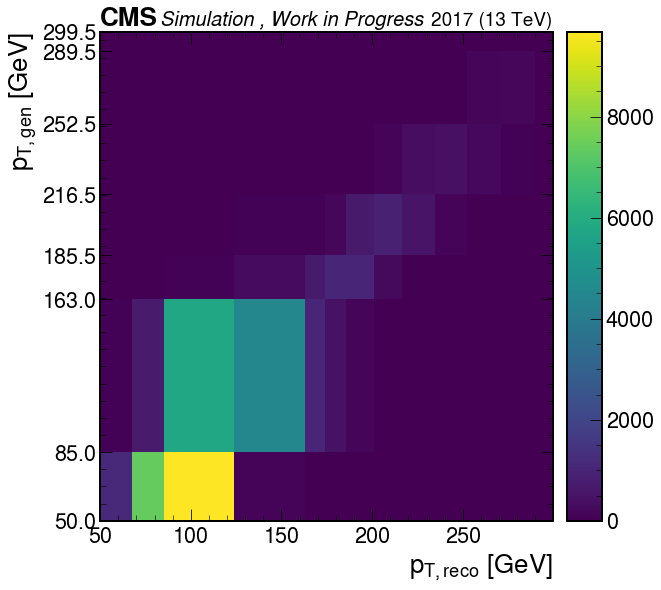

In [41]:
migmat = build_migration_matrix(
    hist.axis.Variable(final_mjet_reco_binning,name='mjet_reco',overflow=flow),
    hist.axis.Variable(final_mjet_gen_binning,name='mjet_gen',overflow=flow),
    events_sel.mjet,
    events_sel.mjetgen,
    events_sel.weight
)

f,ax = fax()
hep.hist2dplot(migmat.to_numpy(),ax=ax)

cms_label(ax)
ax.set_xlabel(r'$p_{T,\mathrm{reco}}~$[GeV]')
ax.set_ylabel(r'$p_{T,\mathrm{gen}}~$[GeV]')
f.savefig(f'unfolding_binning_plots/mjet_2d_optimized_binning_{threshold_str}.pdf',bbox_inches='tight',transparent=True)


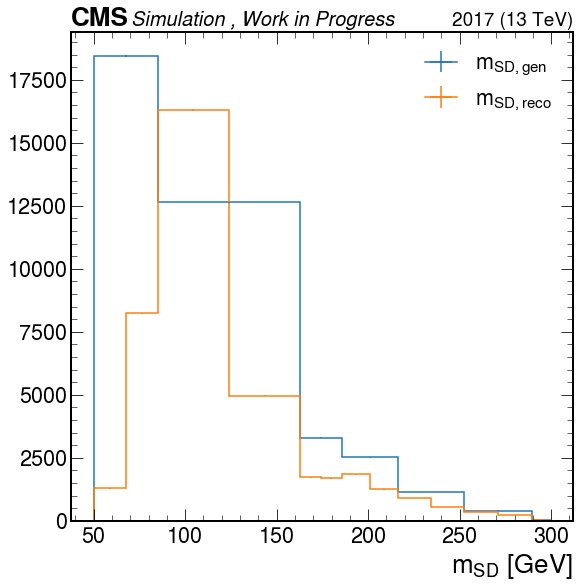

In [42]:
f,ax = fax()

hep.histplot(migmat[::sum,:],ax=ax,label=r'$m_{SD,\mathrm{gen}}$')
hep.histplot(migmat[:,::sum],ax=ax,label=r'$m_{SD,\mathrm{reco}}$')
ax.legend()

ax.set_xlabel(r'$m_{SD}~$[GeV]')
cms_label(ax)
f.savefig(f'unfolding_binning_plots/mjet_optimized_binning_{threshold_str}.pdf',bbox_inches='tight',transparent=True)


## Optimize $m_{SD}$ binning in each $p_T$ bin separately

Now we try to do the same but for each pT bin separately. Maybe the migration matrix is diagnonal in each pT bin?

### Optimization plots function

In [28]:
import seaborn as sns
from matplotlib.colors import LogNorm, Normalize

def optimize_and_plot(events,mjet_correction_factor=1.0,optimizer=None,flow=False):
    #create optimizer with or without correction_factor
    if optimizer is None:
        optimizer = lambda x: create_new_binning_(**x,e = events,reco_corr_factors=mjet_correction_factor)
    #optimizer = lambda x: create_new_binning_(**x,e = events_pt_bin)
    #optimizer = lambda x: create_new_binning_bidirectional_(**x,split_value=85.,e = events_pt_bin)

    #optimize initial mjetgen bining and create mjetreco binning
    final_mjet_gen_binning = optimize_binning(
        initial_mjet_binning,
        threshold=threshold,
        variable='mjet',
        update_binning=optimizer,
    )        
    
    make_optimization_plots(final_mjet_gen_binning,events,mjet_correction_factor=mjet_correction_factor,flow=flow)
    
def make_optimization_plots(final_mjet_gen_binning,events,mjet_correction_factor=1.0,flow=False):
    final_mjet_reco_binning = reco_binning(final_mjet_gen_binning)

    #PLOTS
    
    #build migration matrix with optimized binning
    migmat = build_migration_matrix(
        hist.axis.Variable(final_mjet_gen_binning,name='mjet_reco',overflow=flow),
        hist.axis.Variable(final_mjet_gen_binning,name='mjet_gen',overflow=flow),
        events_pt_bin.mjet*mjet_correction_factor,
        events_pt_bin.mjetgen,
        events_pt_bin.weight,
    )

    #build migration matrix with initial binning
    fine_mjet_binning = np.arange(30,300,2)
    migmat_initial = build_migration_matrix(
        hist.axis.Variable(fine_mjet_binning,name='mjet_reco',overflow=flow),
        hist.axis.Variable(fine_mjet_binning,name='mjet_gen',overflow=flow),
        events_pt_bin.mjet*mjet_correction_factor,
        events_pt_bin.mjetgen,
        events_pt_bin.weight,
    )
    
    #setup figure, grid and first subplots
    #f,(ax1,ax2) = plt.subplots(1,2,figsize=(18,9))
    #f,((ax01,ax02),(ax1,ax2),(cax1,cax2)) = plt.subplots(3,2,figsize=(1))
    f = plt.figure(figsize=(18,18))
    grid = f.add_gridspec(3, 2,hspace=0.3, height_ratios=[1,1,0.05])
    bottom_grid = f.add_gridspec(3, 2,hspace=0.4, height_ratios=[1,1,0.05])
    ax01 = f.add_subplot(grid[0])
    ax02 = f.add_subplot(grid[1])
    

    #plot stability and purity
    hep.histplot(migration_metric(migmat,'mjet_reco',flow=flow),label=f'stability',ax=ax01,**{'color':stability_color})
    hep.histplot(migration_metric(migmat,'mjet_gen',flow=flow),label=f'purity',ax=ax01,**{'color':purity_color})
    ax01.legend(loc='lower center')
    ax01.plot(ax01.get_xlim(),[threshold,threshold],'k--',alpha=0.6)
    #f.savefig(f'unfolding_binning_plots/mjet_optimized_binning_{threshold_str}_metrics.pdf',bbox_inches='tight',transparent=True)
    
    #plot mjetgen with initial and optimized binning and mjetreco with initial binning
    hep.histplot(migmat_initial[::sum,:],ax=ax02,label=r'$m_{SD,\mathrm{gen}}$',density=True)
    hep.histplot(migmat_initial[:,::sum],ax=ax02,label=r'$m_{SD,\mathrm{reco}}$',density=True)
    hep.histplot(migmat[::sum,:],ax=ax02,label=r'$m_{SD,\mathrm{gen}}$ (optimized)',density=True)
    if(mjet_correction_factor != 1.0):
        ax02.text(200,ax02.get_ylim()[1]/2,r'$m_{SD}$ corr. = %.2f'%mjet_correction_factor,fontsize=18)
    ax02.legend()
    ax02.set_xlabel(r'$m_{SD}~$[GeV]')

    ax02.set_title('%s $\leq p_T $< %s'%(str(pt_low),str(pt_high)),fontsize=24)
    cms_label(ax01)
    
    
    #MIGMAT renormed plot
    ax1 = f.add_subplot(bottom_grid[2])
    ax2 = f.add_subplot(bottom_grid[3])
    cax1 = f.add_subplot(bottom_grid[4])
    cax2 = f.add_subplot(bottom_grid[5])
    migmat_mjet_arr,bins_x,bins_y = migmat_initial.to_numpy()
    migmat_mjet_genax_normed = (migmat_mjet_arr.T/np.sum(migmat_mjet_arr.T,axis=1)[:,None]).T
    migmat_mjet_recoax_normed = (migmat_mjet_arr/np.sum(migmat_mjet_arr,axis=1)[:,None])


    #f, ((cax1,cax2),(ax1,ax2)) = plt.subplots(ncols=2,nrows=2, figsize=(18,9),  gridspec_kw={"width_ratios":[1,1],'height_ratios':[1/40,1]})

    g1 = sns.heatmap(migmat_mjet_genax_normed.T,ax=ax1,norm=LogNorm(),cbar = False)
    f.colorbar(ax1.get_children()[0], cax=cax1, orientation="horizontal")
    ax1.set_title('renormed along gen-axis',fontsize=20)
    g2 = sns.heatmap(migmat_mjet_recoax_normed.T,ax=ax2,norm=LogNorm(),cbar = False)
    ax2.set_title('renormed along reco-axis',fontsize=20)
    f.colorbar(ax2.get_children()[0], cax=cax2, orientation="horizontal")

    #f.tight_layout()
    every_nth_tick = 50
    tick_positions = np.arange(0,len(bins_x),every_nth_tick)
    tick_labels = bins_x[::every_nth_tick]
    for ax in [ax1,ax2]:
        ax.invert_yaxis()
        ax.set_xticks(tick_positions)
        ax.set_xticklabels(tick_labels)
        ax.set_yticks(tick_positions)
        ax.set_yticklabels(tick_labels)
        ax.set_xlabel('$m_{SD,\mathrm{reco}}~$[GeV]')
        ax.set_ylabel('$m_{SD,\mathrm{gen}}~$[GeV]')
    return f

### Optimization with plain $m_{SD}$ reco

/nfs/dust/cms/user/albrechs/miniconda3/envs/coffea/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


491 -> 490
441 -> 440
391 -> 390
341 -> 340
291 -> 290
241 -> 240
191 -> 190
141 -> 140
91 -> 90
41 -> 40
Final binning: [ 30.   38.   48.5  59.5  85.  144.5 160.  176.5 202.5 299.5]
bin widths: [ 8.  10.5 11.  25.5 59.5 15.5 16.5 26.  97. ]


/nfs/dust/cms/user/albrechs/miniconda3/envs/coffea/lib/python3.7/site-packages/ipykernel_launcher.py:80: RuntimeWarning: invalid value encountered in true_divide
/nfs/dust/cms/user/albrechs/miniconda3/envs/coffea/lib/python3.7/site-packages/ipykernel_launcher.py:81: RuntimeWarning: invalid value encountered in true_divide
/nfs/dust/cms/user/albrechs/miniconda3/envs/coffea/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


491 -> 490
441 -> 440
391 -> 390
341 -> 340
291 -> 290
241 -> 240
191 -> 190
141 -> 140
91 -> 90
41 -> 40
Final binning: [ 30.   36.5  46.5  58.5  88.5 176.  203.  299.5]
bin widths: [ 6.5 10.  12.  30.  87.5 27.  96.5]


/nfs/dust/cms/user/albrechs/miniconda3/envs/coffea/lib/python3.7/site-packages/ipykernel_launcher.py:80: RuntimeWarning: invalid value encountered in true_divide
/nfs/dust/cms/user/albrechs/miniconda3/envs/coffea/lib/python3.7/site-packages/ipykernel_launcher.py:81: RuntimeWarning: invalid value encountered in true_divide
/nfs/dust/cms/user/albrechs/miniconda3/envs/coffea/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


491 -> 490
441 -> 440
391 -> 390
341 -> 340
291 -> 290
241 -> 240
191 -> 190
141 -> 140
91 -> 90
41 -> 40
Final binning: [ 30.   42.5  54.   67.   87.5 177.  205.  236.  299.5]
bin widths: [12.5 11.5 13.  20.5 89.5 28.  31.  63.5]


/nfs/dust/cms/user/albrechs/miniconda3/envs/coffea/lib/python3.7/site-packages/ipykernel_launcher.py:80: RuntimeWarning: invalid value encountered in true_divide
/nfs/dust/cms/user/albrechs/miniconda3/envs/coffea/lib/python3.7/site-packages/ipykernel_launcher.py:81: RuntimeWarning: invalid value encountered in true_divide
/nfs/dust/cms/user/albrechs/miniconda3/envs/coffea/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


491 -> 490
441 -> 440
391 -> 390
341 -> 340
291 -> 290
241 -> 240
191 -> 190
141 -> 140
91 -> 90
41 -> 40
Final binning: [ 30.   55.5  78.5  89.  160.5 188.5 219.5 251.5 284.5 299.5]
bin widths: [25.5 23.  10.5 71.5 28.  31.  32.  33.  15. ]


/nfs/dust/cms/user/albrechs/miniconda3/envs/coffea/lib/python3.7/site-packages/ipykernel_launcher.py:81: RuntimeWarning: invalid value encountered in true_divide
/nfs/dust/cms/user/albrechs/miniconda3/envs/coffea/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


491 -> 490
441 -> 440
391 -> 390
341 -> 340
291 -> 290
241 -> 240
191 -> 190
141 -> 140
91 -> 90
41 -> 40
Final binning: [ 30.   30.5  31.   31.5  32.   32.5  33.   33.5  34.   34.5  83.  152.5
 174.5 203.  231.5 261.  295.  299.5]
bin widths: [ 0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5 48.5 69.5 22.  28.5 28.5
 29.5 34.   4.5]


/nfs/dust/cms/user/albrechs/miniconda3/envs/coffea/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()
/nfs/dust/cms/user/albrechs/miniconda3/envs/coffea/lib/python3.7/site-packages/ipykernel_launcher.py:80: RuntimeWarning: invalid value encountered in true_divide
/nfs/dust/cms/user/albrechs/miniconda3/envs/coffea/lib/python3.7/site-packages/ipykernel_launcher.py:81: RuntimeWarning: invalid value encountered in true_divide


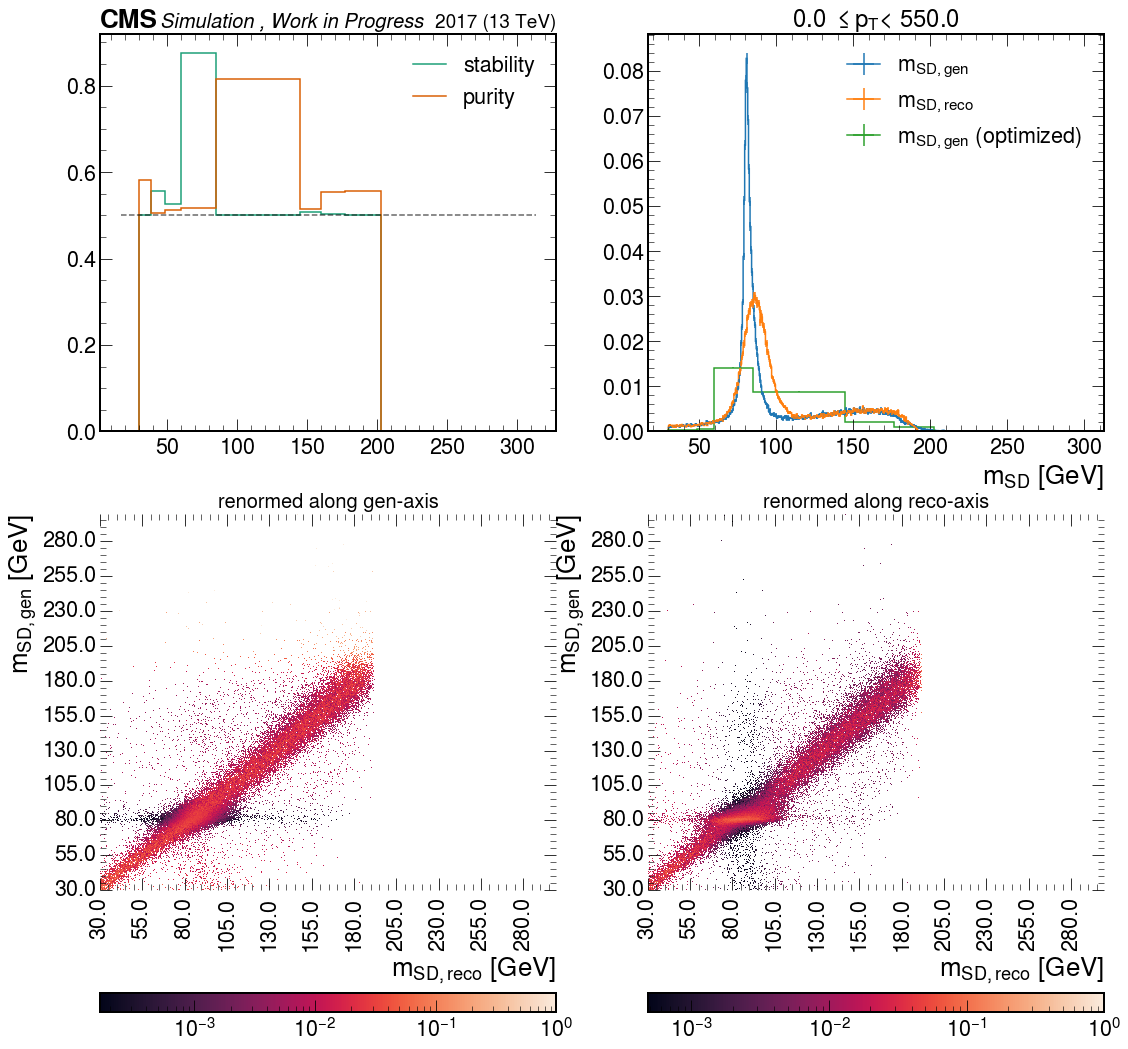

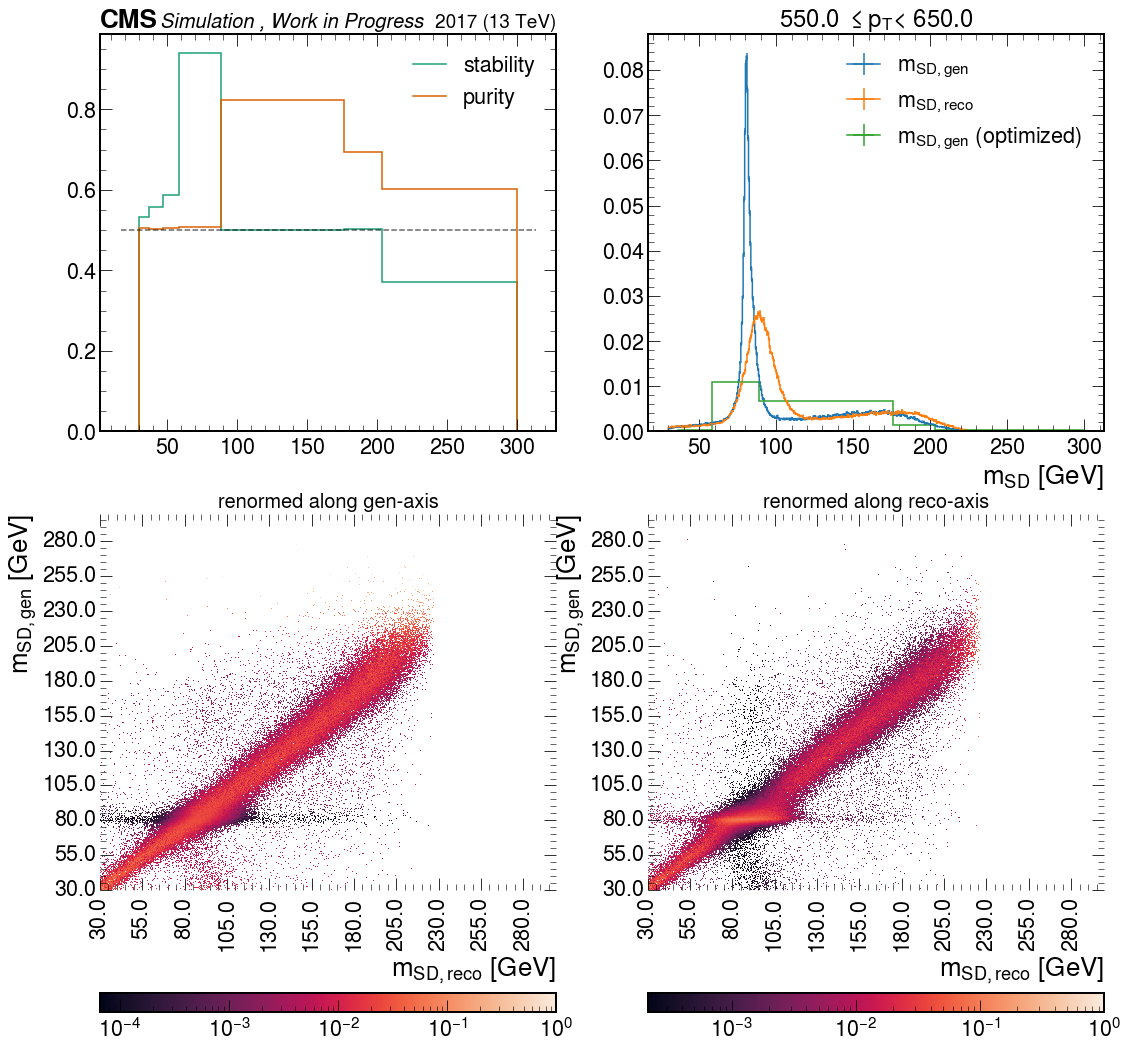

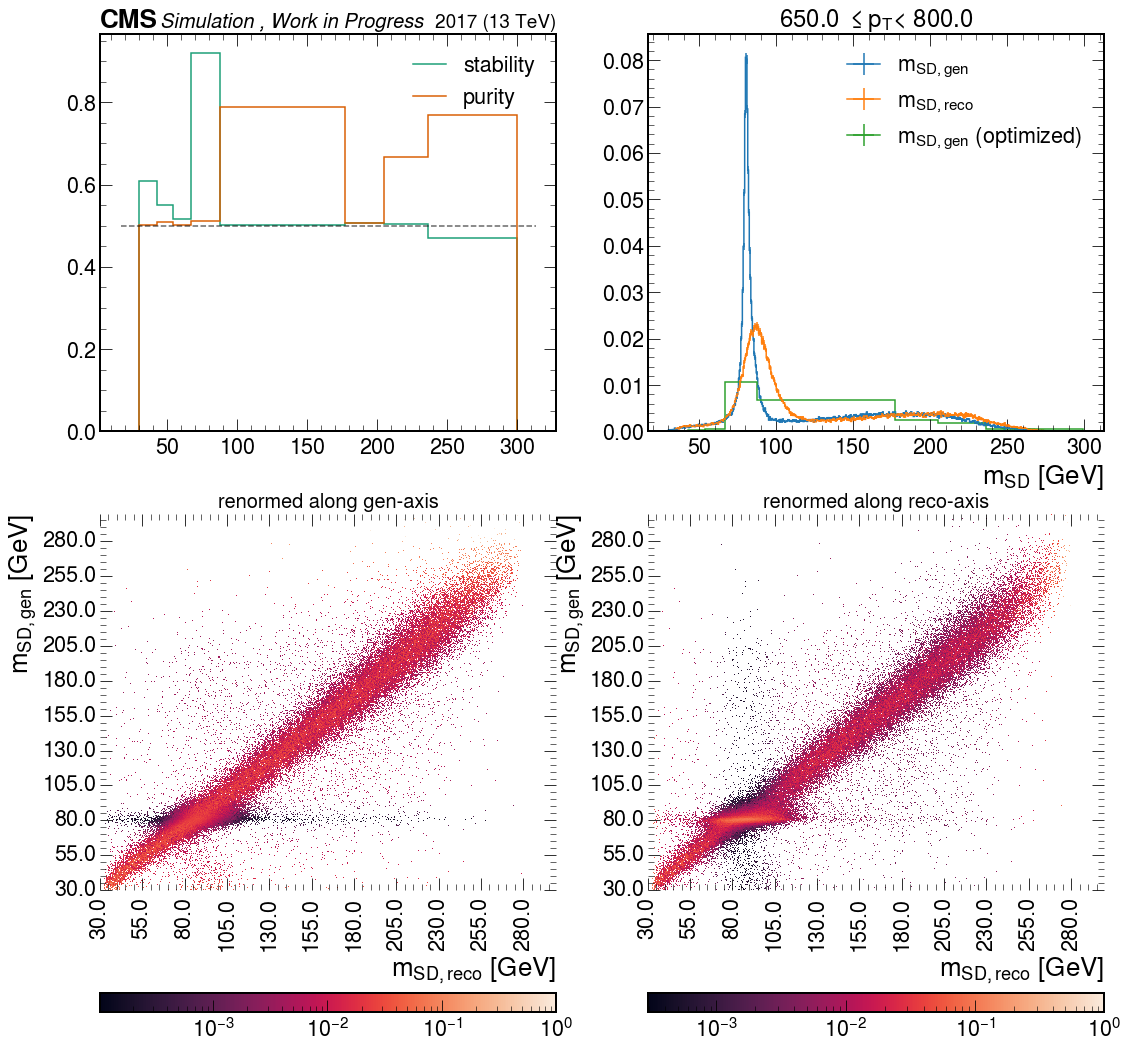

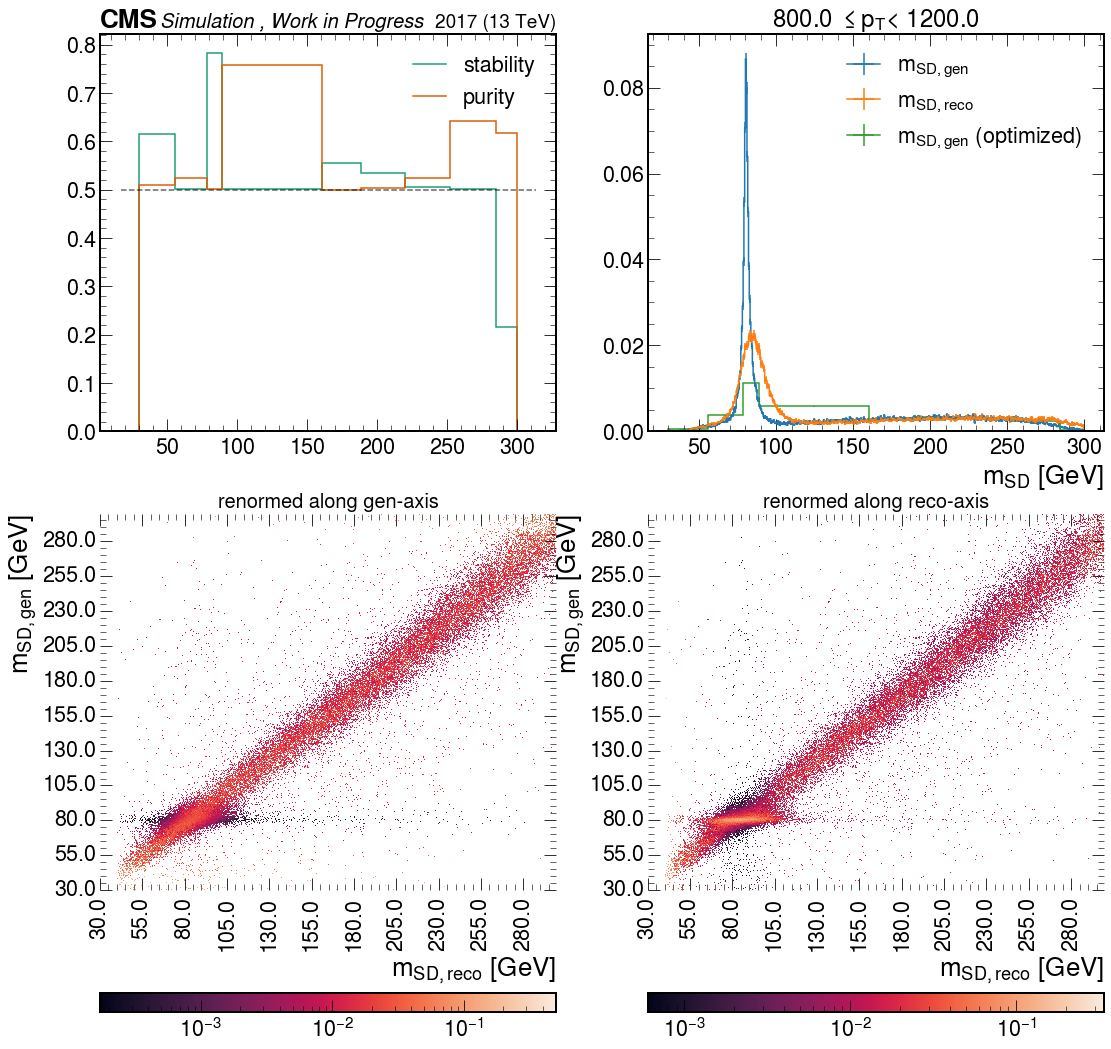

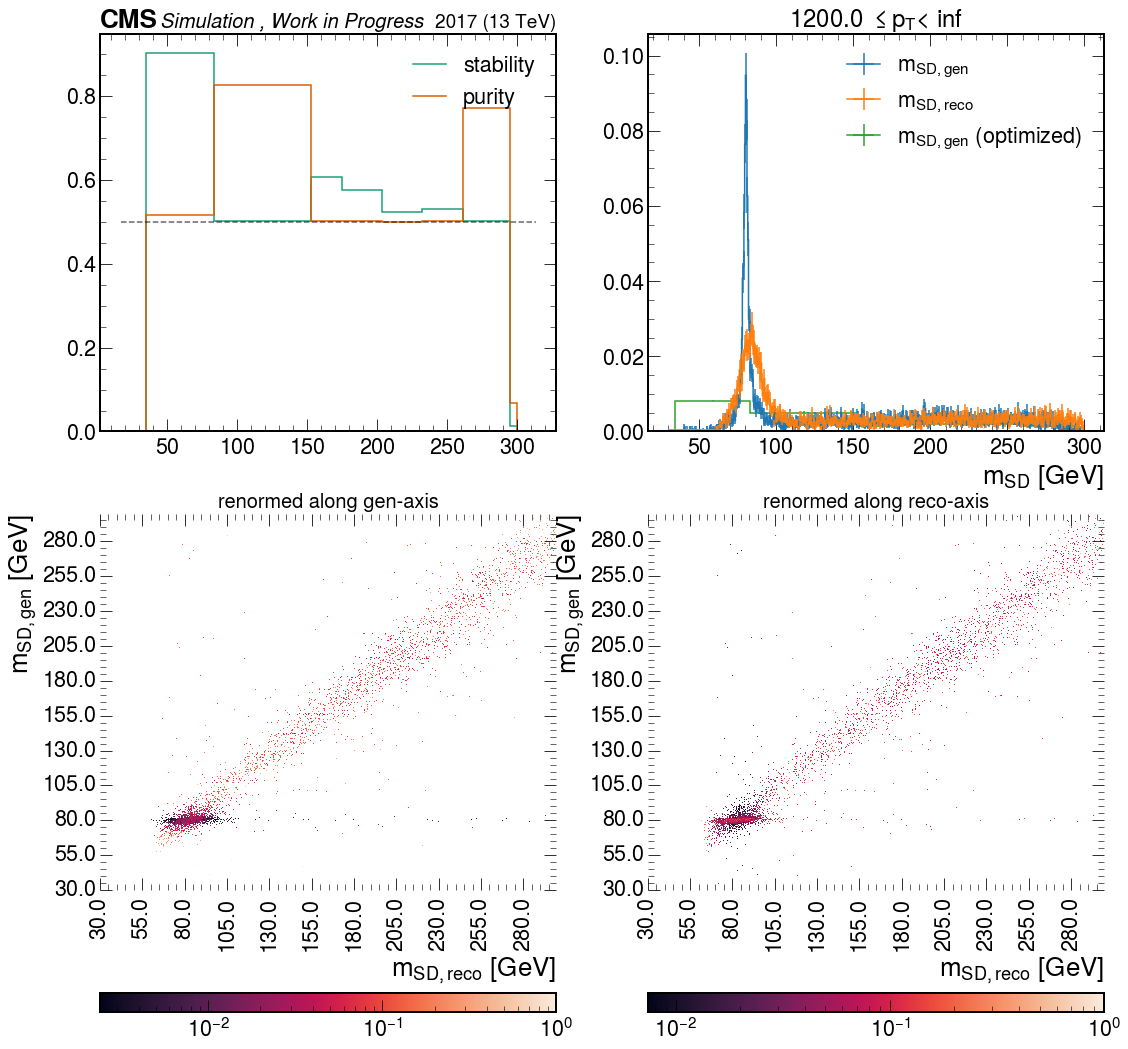

In [184]:
for ipt in range(len(pt_gen_binning)-1):
#for ipt in [2]:
    #select events from current pT bin
    pt_low = pt_gen_binning[ipt]
    pt_high = pt_gen_binning[ipt+1]
    events_pt_bin = events_sel[
        (events_sel.pt>= pt_low)
        &(events_sel.pt<pt_high)
                              ]
    optimize_and_plot(events_pt_bin,mjet_correction_factor=1.0)


### $p_T$ dependent $m_{SD}$ correction factor
For now just consider the ratio of histogram means per reco-pt bin

In [17]:

migmat = hist.Hist(
        hist.axis.Regular(300,0,300,name='mjet_reco',overflow=True),
        hist.axis.Regular(300,0,300,name='mjet_gen',overflow=True),
        #hist.axis.Variable(reco_binning(np.array([0,550, 650, 800, 1200])),name='pt_reco'),
        #hist.axis.Variable(np.array([0,550, 650, 800, 1200]),name='pt_gen'),
        hist.axis.Variable(reco_binning(pt_gen_binning),name='pt_reco'),
        hist.axis.Variable(pt_gen_binning,name='pt_gen'),
        storage = hist.storage.Weight())
migmat.fill(
        mjet_reco = events_sel.mjet,
        mjet_gen = events_sel.mjetgen,
        pt_reco = events_sel.pt,
        pt_gen = events_sel.ptgen,
        weight = events_sel.weight,
)
1+1

2

In [18]:
from scipy.stats import rv_histogram

In [19]:
def peak_pos(h):
    val,bins = h[hist.rebin(3)].to_numpy()
    return bins[val.argmax()]

means_reco = np.array([
    #rv_histogram(migmat[:,::sum,::sum,ipt].to_numpy()).mean()#/
    peak_pos(migmat[:,::sum,::sum,ipt])#/
    #rv_histogram(migmat[::sum,50j:120j,ipt,::sum].to_numpy()).mean()
    for ipt in range(len(migmat.axes[3]))
])
means_gen = np.array([
    #rv_histogram(migmat[50j:120j,::sum,ipt,::sum].to_numpy()).mean()#/
    #rv_histogram(migmat[::sum,:,::sum,ipt].to_numpy()).mean()
    peak_pos(migmat[::sum,:,::sum,ipt])
    for ipt in range(len(migmat.axes[3]))
])

mjet_correction_factors = means_gen/means_reco

Text(80.2675585284281, 0.08371622545561008, 'peak')

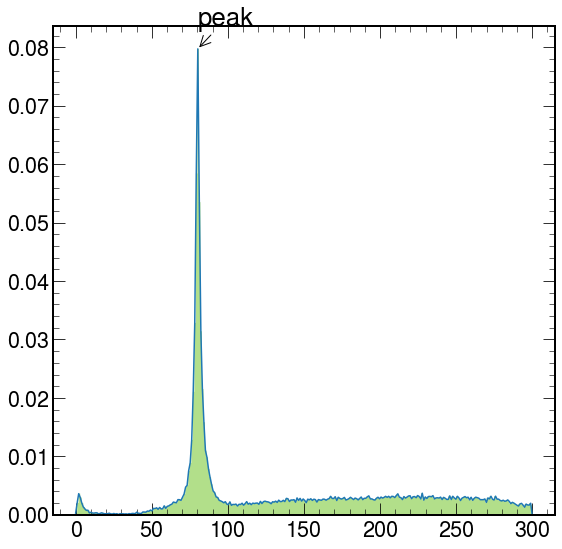

In [20]:
f,ax = fax()
h = migmat[::sum,:,::sum,3].to_numpy()
x = np.linspace(0,300,300)
pdf = rv_histogram(h).pdf(x)
hep.histplot(h,ax=ax,histtype='fill',label='hist',color='#b2df8a',density=True)
ax.plot(x,pdf,'-',color='#1f78b4')
peak_pos = h[0].argmax()
ax.annotate(
    "peak", xy=(x[peak_pos], pdf[peak_pos]), 
            xytext=(x[peak_pos], ax.get_ylim()[1]),
            arrowprops=dict(arrowstyle="->"))

In [21]:
for ipt,pt_low in enumerate(pt_gen_binning[:-1]):
    print(mjet_correction_factors[ipt])

0.896551724137931
0.896551724137931
0.9285714285714284
0.9629629629629629
0.9629629629629629


### Optimization with $p_T$ dependent $m_{SD}$ correction factor

#### Optimizer: one-directional, with correction

/nfs/dust/cms/user/albrechs/miniconda3/envs/coffea/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


491 -> 490
441 -> 440
391 -> 390
341 -> 340
291 -> 290
241 -> 240
191 -> 190
141 -> 140
91 -> 90
41 -> 40
Final binning: [ 30.   42.5  56.5  80.   92.  131.  147.  163.5 182.  201.5 221.5 256.5
 299.5]
bin widths: [12.5 14.  23.5 12.  39.  16.  16.5 18.5 19.5 20.  35.  43. ]


/nfs/dust/cms/user/albrechs/miniconda3/envs/coffea/lib/python3.7/site-packages/ipykernel_launcher.py:80: RuntimeWarning: invalid value encountered in true_divide
/nfs/dust/cms/user/albrechs/miniconda3/envs/coffea/lib/python3.7/site-packages/ipykernel_launcher.py:81: RuntimeWarning: invalid value encountered in true_divide


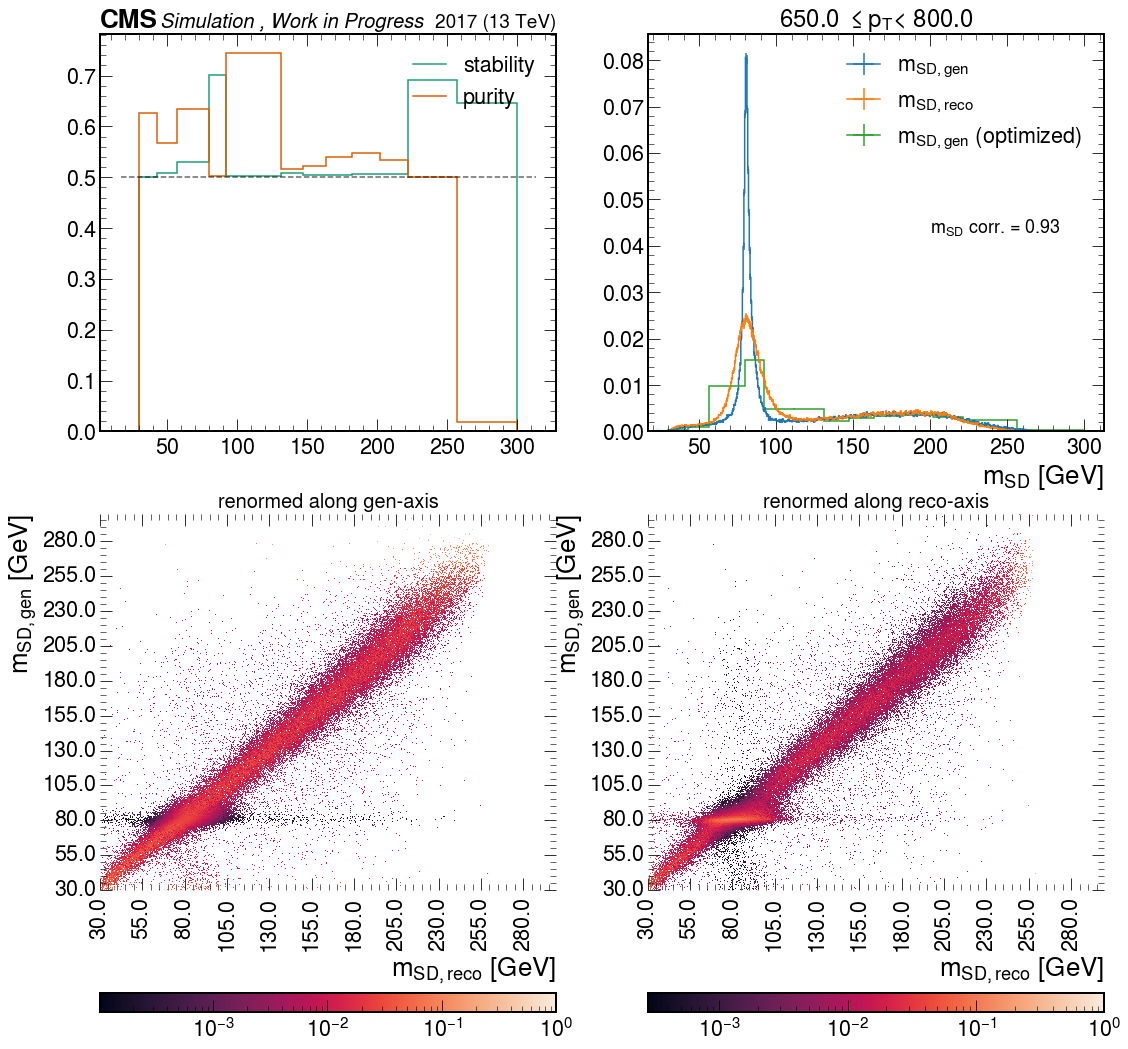

In [191]:
#for ipt in range(len(pt_gen_binning)-1):
for ipt in [2]:
    #select events from current pT bin
    pt_low = pt_gen_binning[ipt]
    pt_high = pt_gen_binning[ipt+1]
    events_pt_bin = events_sel[
        (events_sel.pt>= pt_low)
        &(events_sel.pt<pt_high)
                              ]
    optimize_and_plot(events_pt_bin,mjet_correction_factor=mjet_correction_factors[ipt])

#### Optimizer: bi-directional, with correction and peak_pos as split_value

/nfs/dust/cms/user/albrechs/miniconda3/envs/coffea/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


491 -> 490
441 -> 440
391 -> 390
341 -> 340
291 -> 290
241 -> 240
191 -> 190
141 -> 140
91 -> 90
41 -> 40
Final binning: [ 30.   78.   98.  125.5 156.5 299.5]
bin widths: [ 48.   20.   27.5  31.  143. ]


/nfs/dust/cms/user/albrechs/miniconda3/envs/coffea/lib/python3.7/site-packages/ipykernel_launcher.py:80: RuntimeWarning: invalid value encountered in true_divide
/nfs/dust/cms/user/albrechs/miniconda3/envs/coffea/lib/python3.7/site-packages/ipykernel_launcher.py:81: RuntimeWarning: invalid value encountered in true_divide
/nfs/dust/cms/user/albrechs/miniconda3/envs/coffea/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


491 -> 490
441 -> 440
391 -> 390
341 -> 340
291 -> 290
241 -> 240
191 -> 190
141 -> 140
91 -> 90
41 -> 40
Final binning: [ 30.   78.   89.5 125.  145.5 168.  194.5 299.5]
bin widths: [ 48.   11.5  35.5  20.5  22.5  26.5 105. ]


/nfs/dust/cms/user/albrechs/miniconda3/envs/coffea/lib/python3.7/site-packages/ipykernel_launcher.py:80: RuntimeWarning: invalid value encountered in true_divide
/nfs/dust/cms/user/albrechs/miniconda3/envs/coffea/lib/python3.7/site-packages/ipykernel_launcher.py:81: RuntimeWarning: invalid value encountered in true_divide
/nfs/dust/cms/user/albrechs/miniconda3/envs/coffea/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


491 -> 490
441 -> 440
391 -> 390
341 -> 340
291 -> 290
241 -> 240
191 -> 190
141 -> 140
91 -> 90
41 -> 40
Final binning: [ 30.   78.   89.5 135.5 152.  169.  188.  208.5 229.5 299.5]
bin widths: [48.  11.5 46.  16.5 17.  19.  20.5 21.  70. ]


/nfs/dust/cms/user/albrechs/miniconda3/envs/coffea/lib/python3.7/site-packages/ipykernel_launcher.py:80: RuntimeWarning: invalid value encountered in true_divide
/nfs/dust/cms/user/albrechs/miniconda3/envs/coffea/lib/python3.7/site-packages/ipykernel_launcher.py:81: RuntimeWarning: invalid value encountered in true_divide
/nfs/dust/cms/user/albrechs/miniconda3/envs/coffea/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


491 -> 490
441 -> 440
391 -> 390
341 -> 340
291 -> 290
241 -> 240
191 -> 190
141 -> 140
91 -> 90
41 -> 40
Final binning: [ 30.   78.   88.5 139.5 158.  177.  197.  217.5 239.  262.  283.5 299.5]
bin widths: [48.  10.5 51.  18.5 19.  20.  20.5 21.5 23.  21.5 16. ]


/nfs/dust/cms/user/albrechs/miniconda3/envs/coffea/lib/python3.7/site-packages/ipykernel_launcher.py:81: RuntimeWarning: invalid value encountered in true_divide
/nfs/dust/cms/user/albrechs/miniconda3/envs/coffea/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


491 -> 490
441 -> 440
391 -> 390
341 -> 340
291 -> 290
241 -> 240
191 -> 190
141 -> 140
91 -> 90
41 -> 40
Final binning: [ 30.   78.   87.5 124.  139.5 156.  173.5 194.5 215.5 239.5 261.5 283.
 298.  299.5]
bin widths: [48.   9.5 36.5 15.5 16.5 17.5 21.  21.  24.  22.  21.5 15.   1.5]


/nfs/dust/cms/user/albrechs/miniconda3/envs/coffea/lib/python3.7/site-packages/ipykernel_launcher.py:80: RuntimeWarning: invalid value encountered in true_divide
/nfs/dust/cms/user/albrechs/miniconda3/envs/coffea/lib/python3.7/site-packages/ipykernel_launcher.py:81: RuntimeWarning: invalid value encountered in true_divide


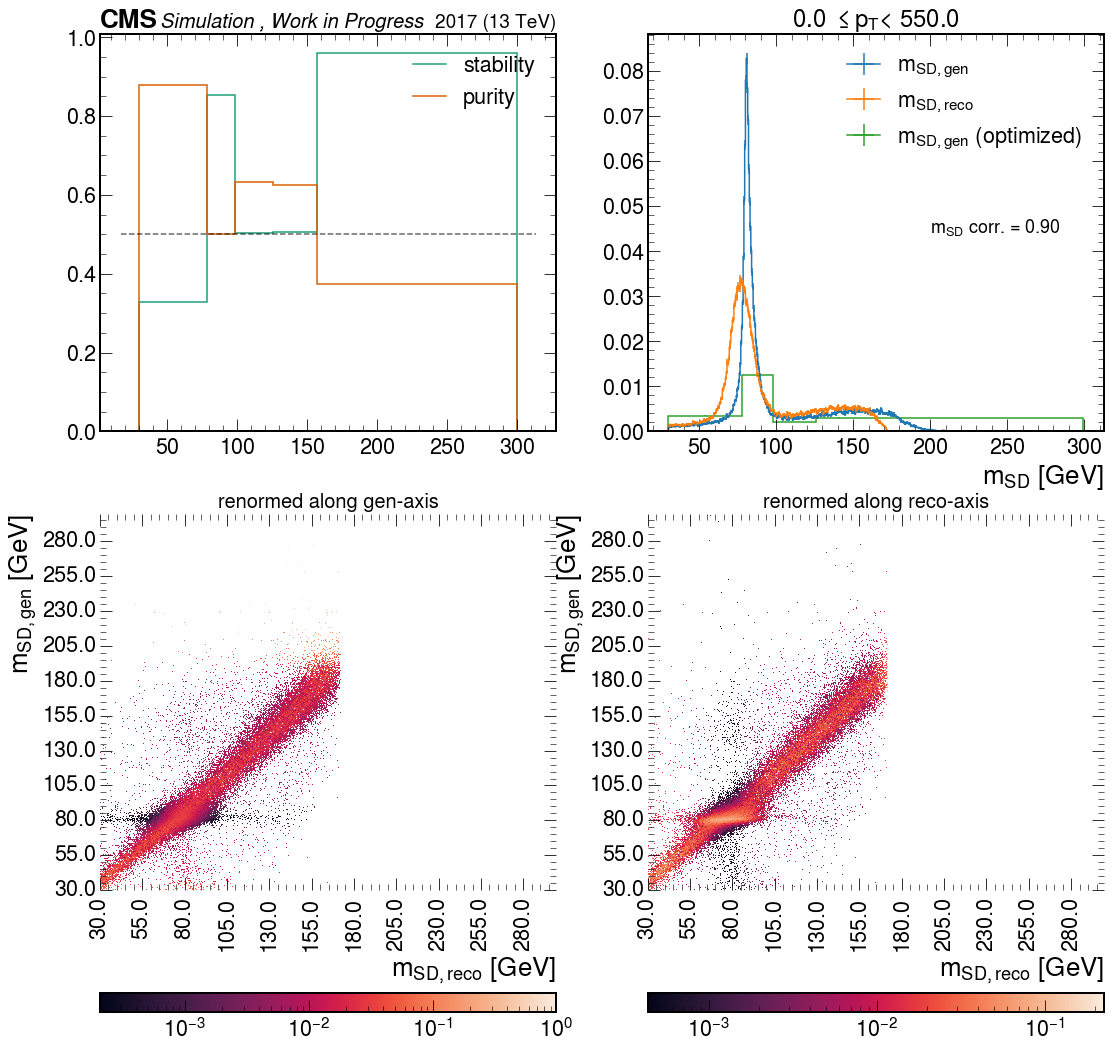

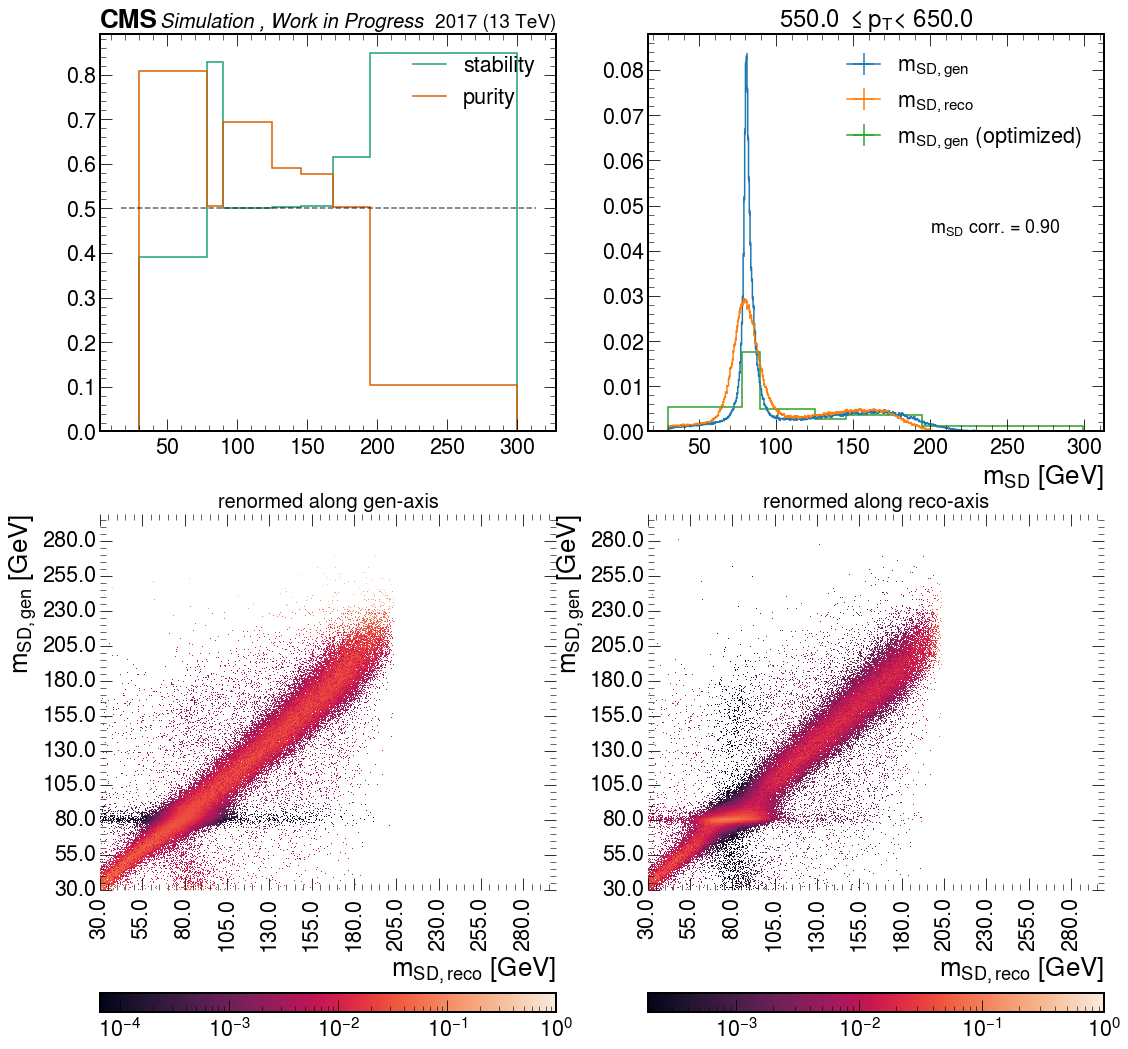

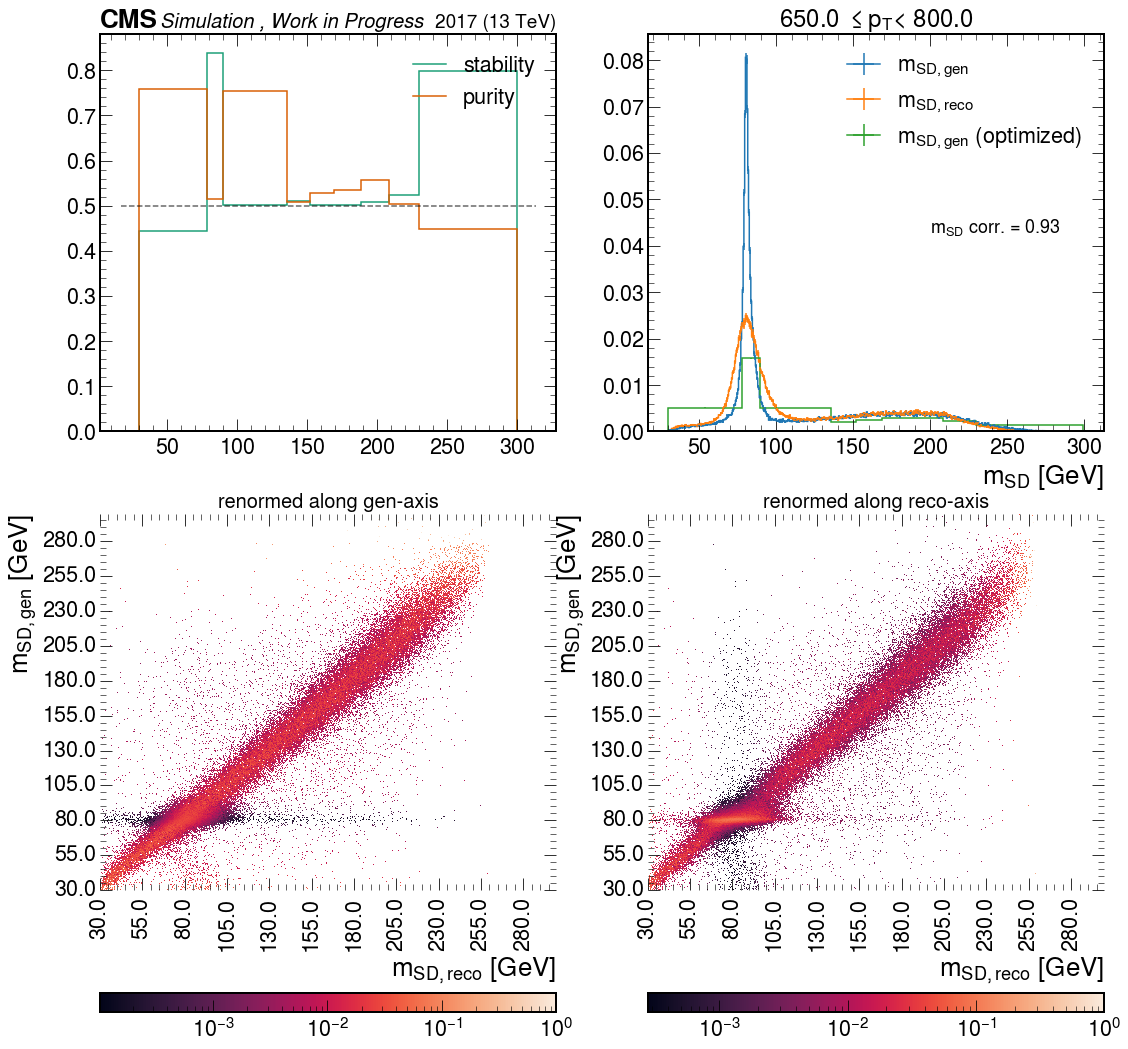

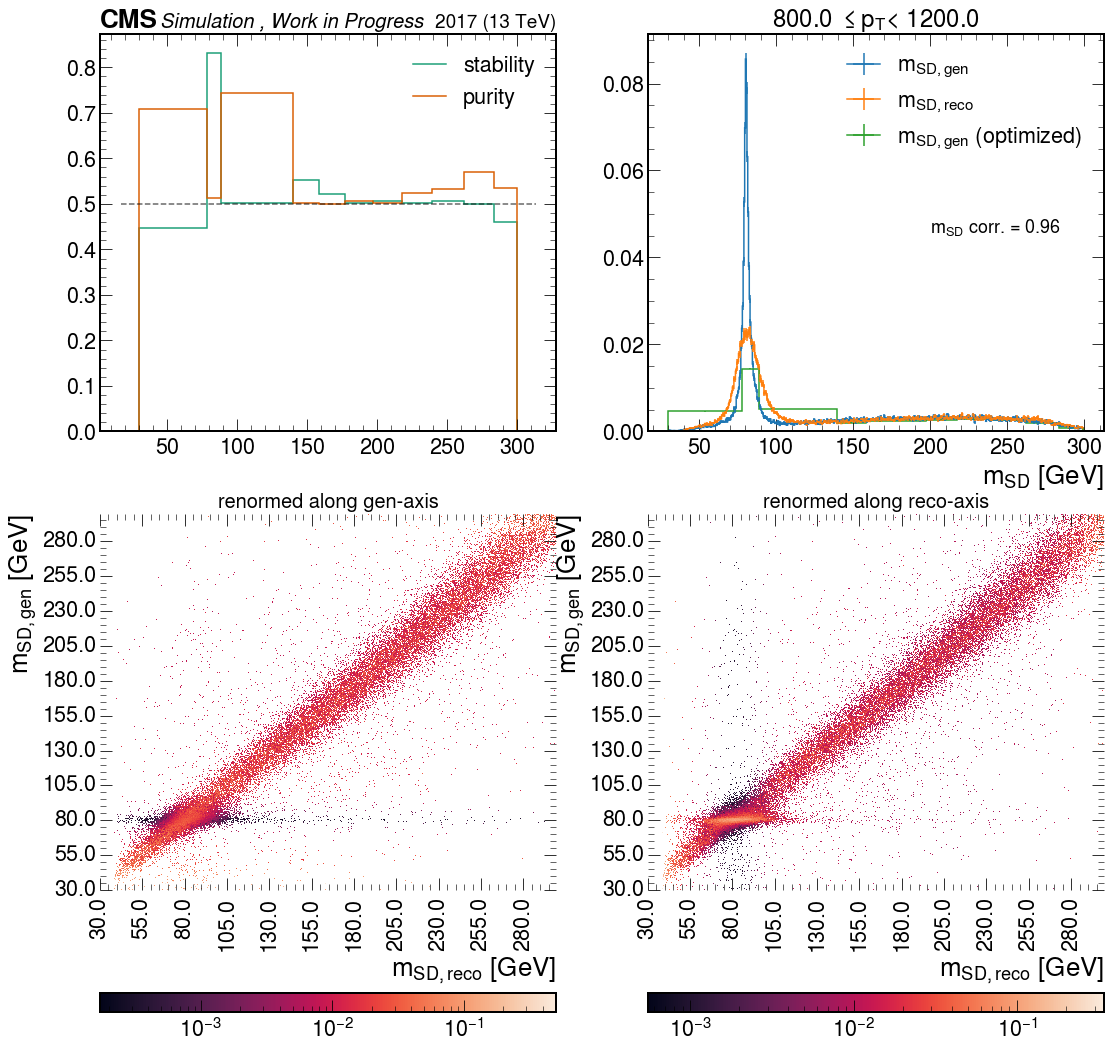

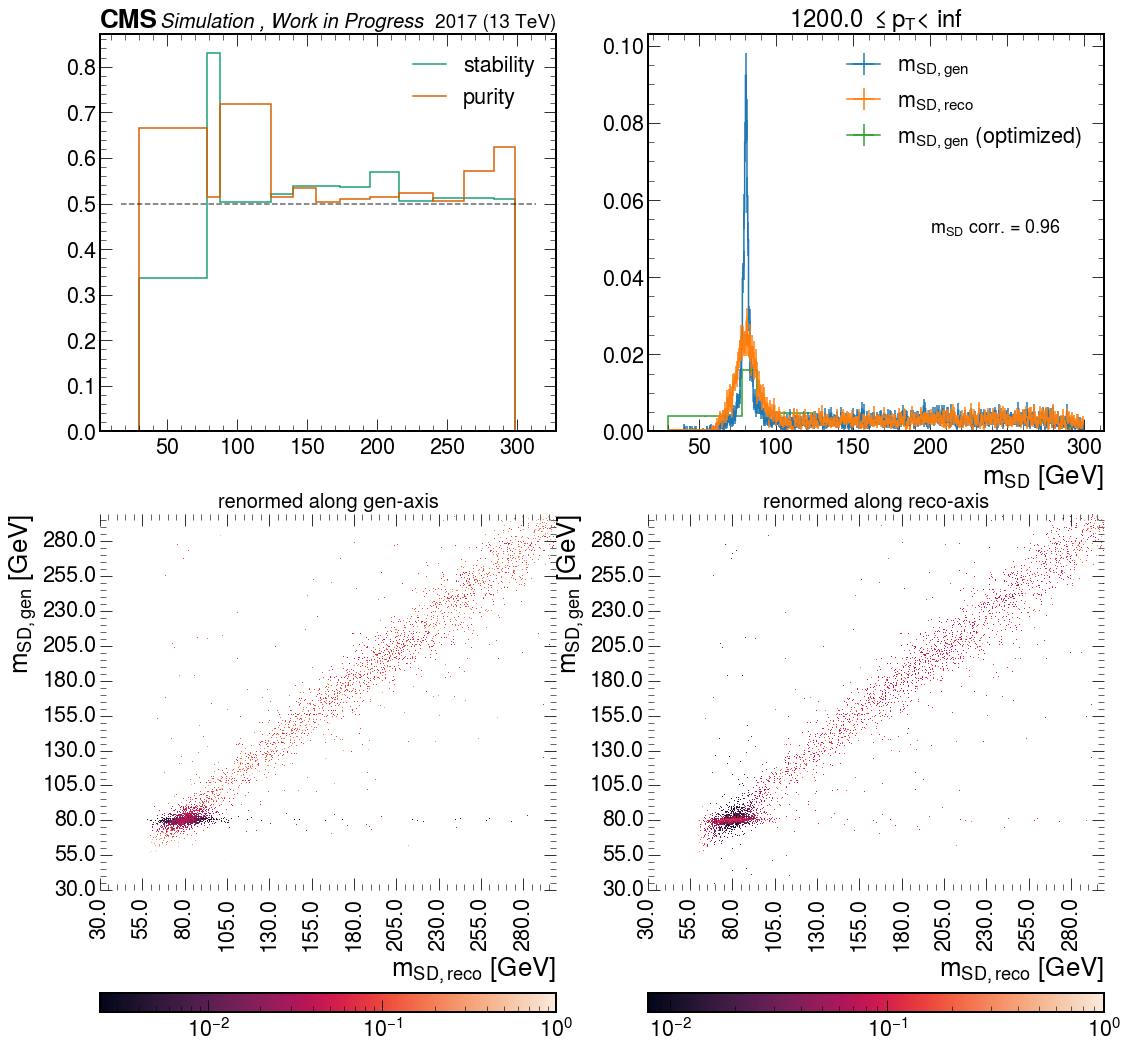

In [192]:
for ipt in range(len(pt_gen_binning)-1):
#for ipt in [2]:
    #select events from current pT bin
    pt_low = pt_gen_binning[ipt]
    pt_high = pt_gen_binning[ipt+1]
    events_pt_bin = events_sel[
        (events_sel.pt>= pt_low)
        &(events_sel.pt<pt_high)
                              ]
    bidirect_optimizer = lambda x: create_new_binning_bidirectional_(**x,e = events_pt_bin,reco_corr_factors=mjet_correction_factors[ipt],split_value=means_gen[ipt])
    optimize_and_plot(events_pt_bin,mjet_correction_factor=mjet_correction_factors[ipt],optimizer = bidirect_optimizer)
    #make_optimization_plots(events_pt_bin,mjet_correction_factor=mjet_correction_factors[ipt])

#### Optimizer: bi-directional, with correction and and 81. as split_value

/nfs/dust/cms/user/albrechs/miniconda3/envs/coffea/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


491 -> 490
441 -> 440
391 -> 390
341 -> 340
291 -> 290
241 -> 240
191 -> 190
141 -> 140
91 -> 90
41 -> 40
Final binning: [ 30.   33.   63.   81.  118.5 148.5 183.  299.5]
bin widths: [  3.   30.   18.   37.5  30.   34.5 116.5]


/nfs/dust/cms/user/albrechs/miniconda3/envs/coffea/lib/python3.7/site-packages/ipykernel_launcher.py:80: RuntimeWarning: invalid value encountered in true_divide
/nfs/dust/cms/user/albrechs/miniconda3/envs/coffea/lib/python3.7/site-packages/ipykernel_launcher.py:81: RuntimeWarning: invalid value encountered in true_divide
/nfs/dust/cms/user/albrechs/miniconda3/envs/coffea/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


491 -> 490
441 -> 440
391 -> 390
341 -> 340
291 -> 290
241 -> 240
191 -> 190
141 -> 140
91 -> 90
41 -> 40
Final binning: [ 30.   71.   81.   95.  120.5 140.5 162.5 184.5 299.5]
bin widths: [ 41.   10.   14.   25.5  20.   22.   22.  115. ]


/nfs/dust/cms/user/albrechs/miniconda3/envs/coffea/lib/python3.7/site-packages/ipykernel_launcher.py:80: RuntimeWarning: invalid value encountered in true_divide
/nfs/dust/cms/user/albrechs/miniconda3/envs/coffea/lib/python3.7/site-packages/ipykernel_launcher.py:81: RuntimeWarning: invalid value encountered in true_divide
/nfs/dust/cms/user/albrechs/miniconda3/envs/coffea/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


491 -> 490
441 -> 440
391 -> 390
341 -> 340
291 -> 290
241 -> 240
191 -> 190
141 -> 140
91 -> 90
41 -> 40
Final binning: [ 30.   37.   69.5  81.   94.  128.  144.  160.5 178.  197.5 217.5 246.
 299.5]
bin widths: [ 7.  32.5 11.5 13.  34.  16.  16.5 17.5 19.5 20.  28.5 53.5]


/nfs/dust/cms/user/albrechs/miniconda3/envs/coffea/lib/python3.7/site-packages/ipykernel_launcher.py:80: RuntimeWarning: invalid value encountered in true_divide
/nfs/dust/cms/user/albrechs/miniconda3/envs/coffea/lib/python3.7/site-packages/ipykernel_launcher.py:81: RuntimeWarning: invalid value encountered in true_divide
/nfs/dust/cms/user/albrechs/miniconda3/envs/coffea/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


491 -> 490
441 -> 440
391 -> 390
341 -> 340
291 -> 290
241 -> 240
191 -> 190
141 -> 140
91 -> 90
41 -> 40
Final binning: [ 30.   43.   68.5  81.   93.5 128.  145.  163.5 182.5 203.  223.  244.5
 267.  288.  299.5]
bin widths: [13.  25.5 12.5 12.5 34.5 17.  18.5 19.  20.5 20.  21.5 22.5 21.  11.5]


/nfs/dust/cms/user/albrechs/miniconda3/envs/coffea/lib/python3.7/site-packages/ipykernel_launcher.py:81: RuntimeWarning: invalid value encountered in true_divide
/nfs/dust/cms/user/albrechs/miniconda3/envs/coffea/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


491 -> 490
441 -> 440
391 -> 390
341 -> 340
291 -> 290
241 -> 240
191 -> 190
141 -> 140
91 -> 90
41 -> 40
Final binning: [ 30.   71.5  81.   95.  118.5 134.5 150.  170.5 191.  212.  237.5 260.
 282.  297.  299.5]
bin widths: [41.5  9.5 14.  23.5 16.  15.5 20.5 20.5 21.  25.5 22.5 22.  15.   2.5]


/nfs/dust/cms/user/albrechs/miniconda3/envs/coffea/lib/python3.7/site-packages/ipykernel_launcher.py:80: RuntimeWarning: invalid value encountered in true_divide
/nfs/dust/cms/user/albrechs/miniconda3/envs/coffea/lib/python3.7/site-packages/ipykernel_launcher.py:81: RuntimeWarning: invalid value encountered in true_divide


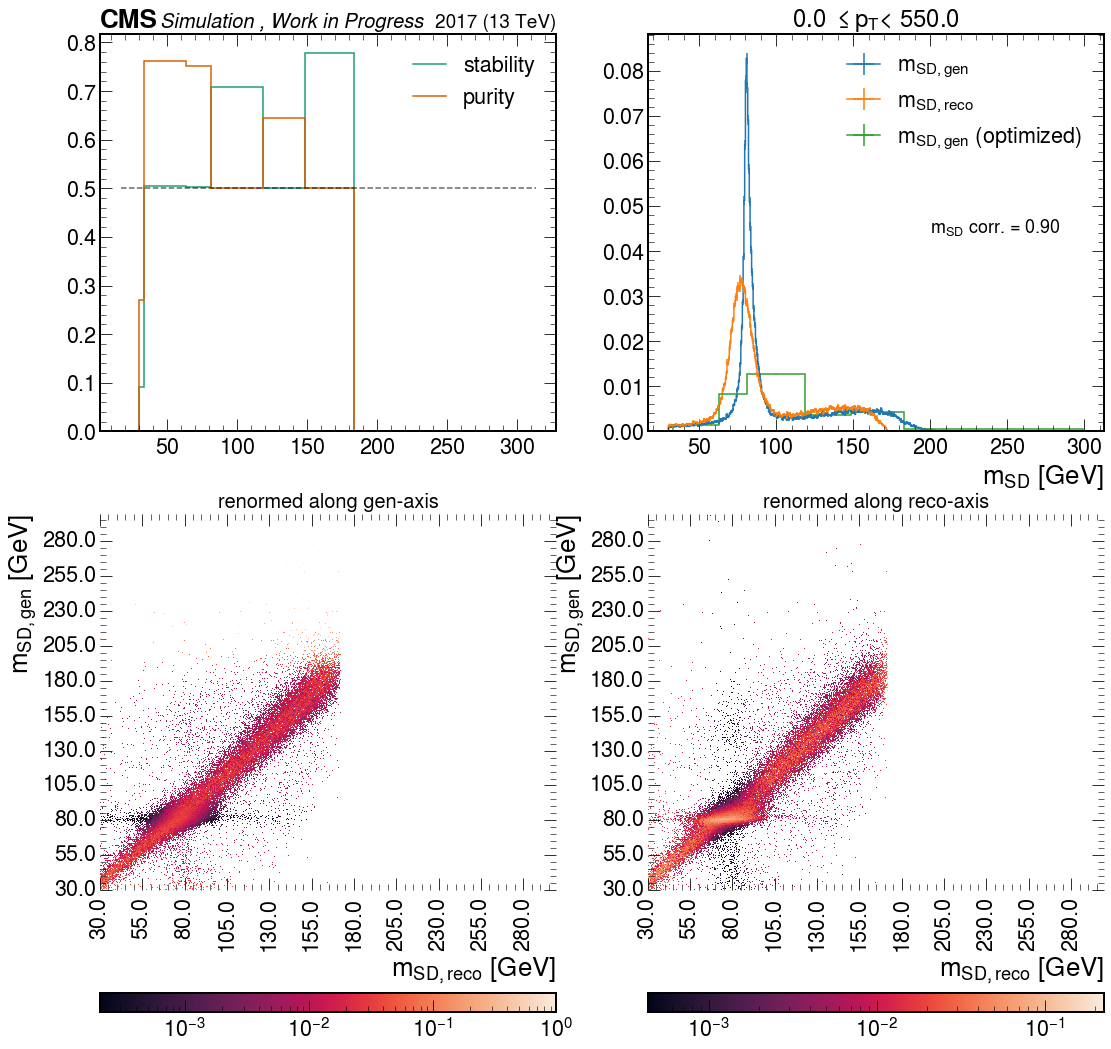

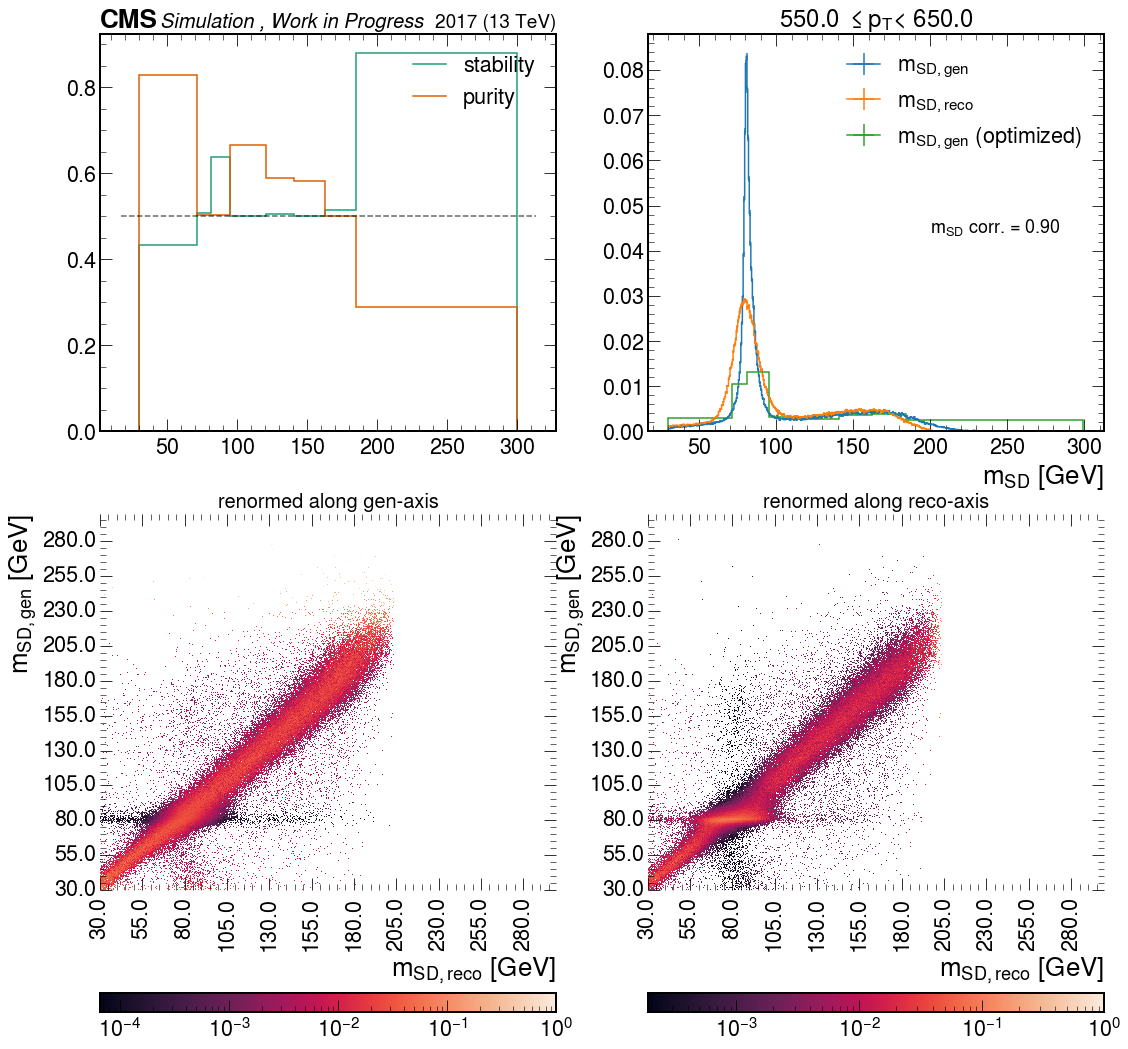

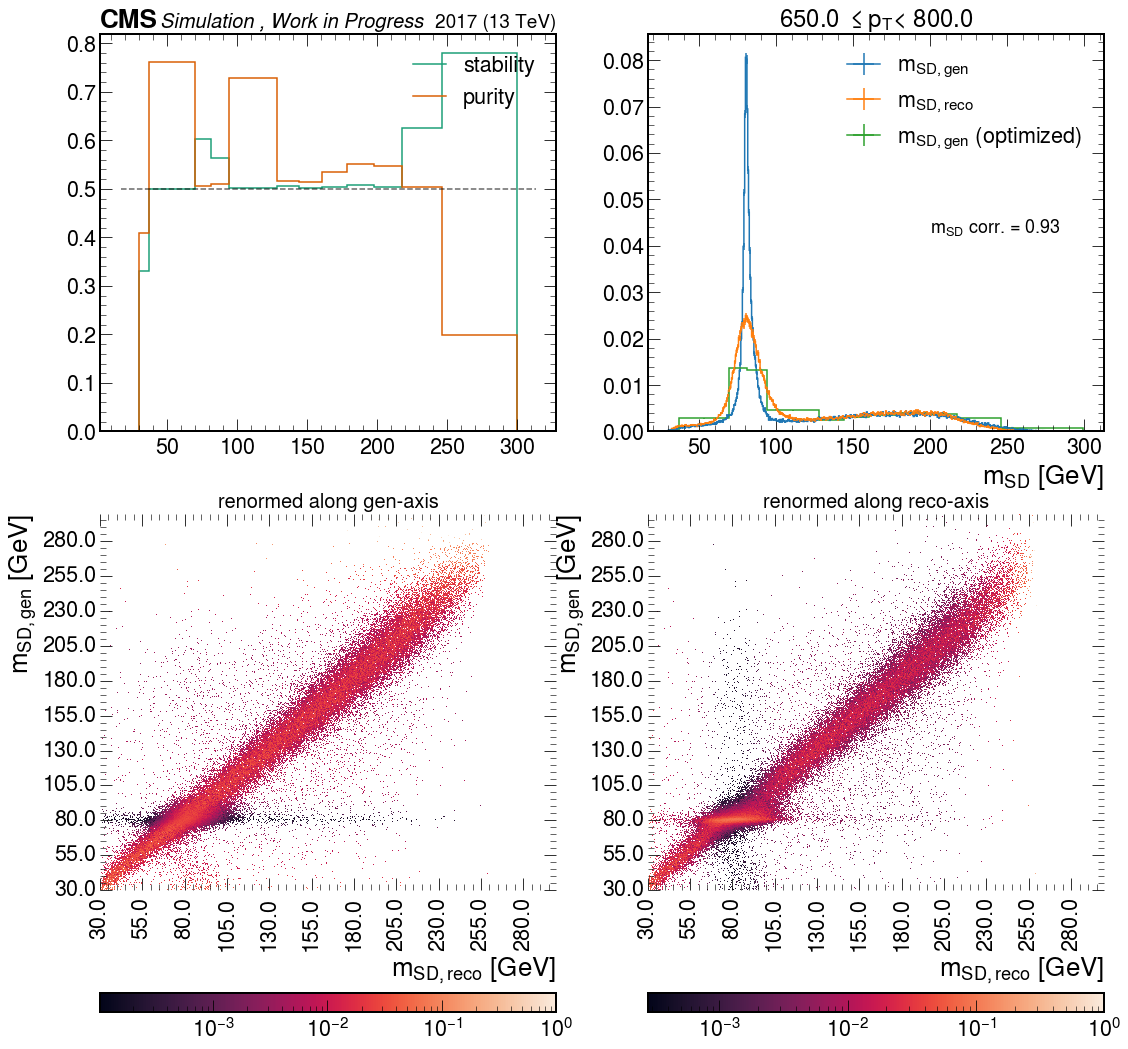

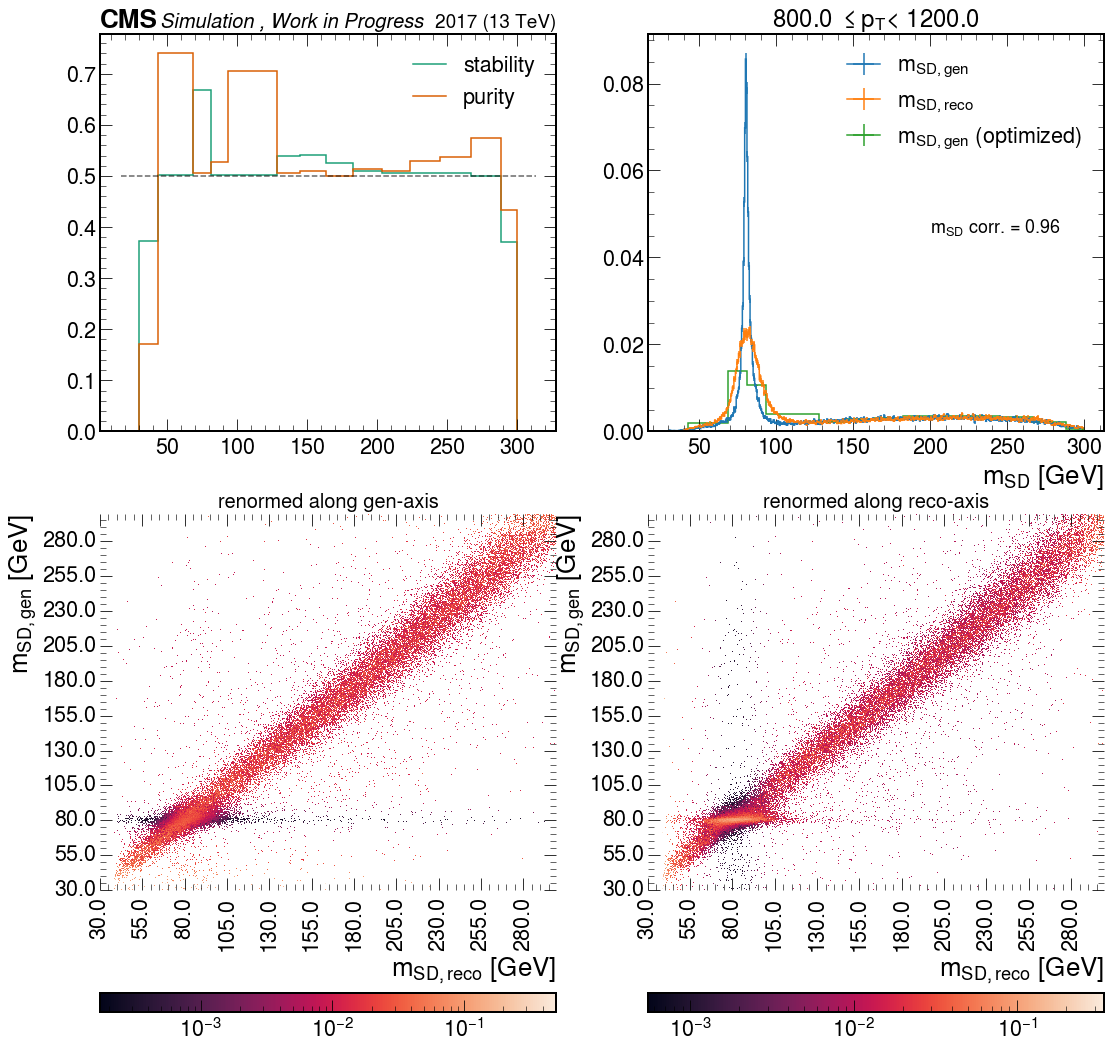

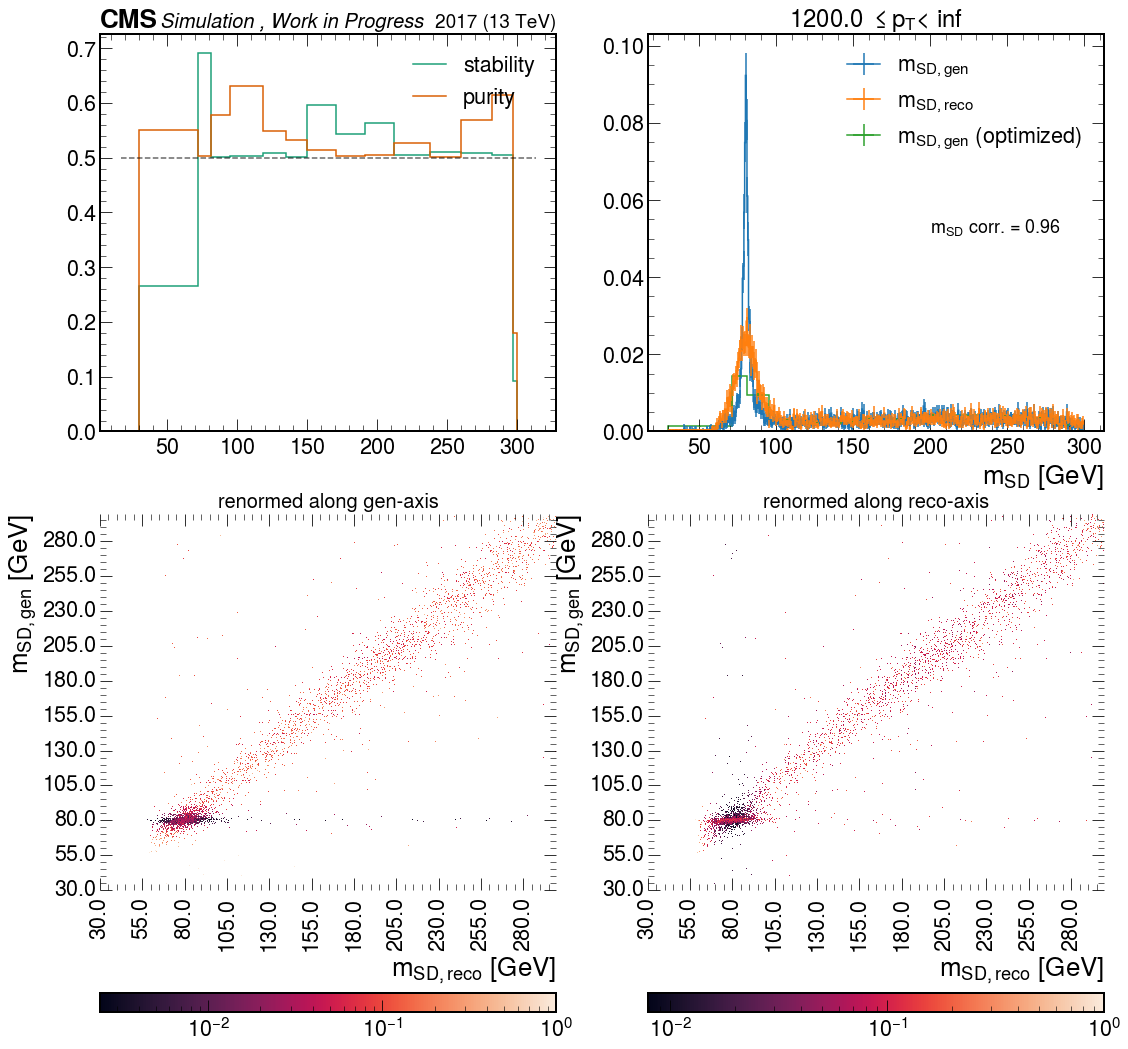

In [193]:
for ipt in range(len(pt_gen_binning)-1):
#for ipt in [2]:
    #select events from current pT bin
    pt_low = pt_gen_binning[ipt]
    pt_high = pt_gen_binning[ipt+1]
    events_pt_bin = events_sel[
        (events_sel.pt>= pt_low)
        &(events_sel.pt<pt_high)
                              ]
    bidirect_optimizer = lambda x: create_new_binning_bidirectional_(**x,e = events_pt_bin,reco_corr_factors=mjet_correction_factors[ipt],split_value=81.)
    optimize_and_plot(events_pt_bin,mjet_correction_factor=mjet_correction_factors[ipt],optimizer = bidirect_optimizer)
    #make_optimization_plots(events_pt_bin,mjet_correction_factor=mjet_correction_factors[ipt])

## (semi-)final choice of $m_{SD}$ binning

choosing pt binning from pt=[800,1200]: [ 30.   43.   68.5  81.   93.5 128.  145.  163.5 182.5 203.  223.  244.5
 267.  288.  299.5] but remove first bin and merge last two bins:

In [22]:
semifinal_mjet_binning = np.array([  43.,   68.5,  81.,   93.5, 128.,  145.,  163.5, 182.5, 203.,  223.,  244.5,
 267., 299.5])

In [31]:
semifinal_mjet_binning

array([ 43. ,  68.5,  81. ,  93.5, 128. , 145. , 163.5, 182.5, 203. ,
       223. , 244.5, 267. , 299.5])

In [33]:
reco_binning(semifinal_mjet_binning)

array([ 43.  ,  55.75,  68.5 ,  74.75,  81.  ,  87.25,  93.5 , 110.75,
       128.  , 136.5 , 145.  , 154.25, 163.5 , 173.  , 182.5 , 192.75,
       203.  , 213.  , 223.  , 233.75, 244.5 , 255.75, 267.  , 283.25,
       299.5 ])

/nfs/dust/cms/user/albrechs/miniconda3/envs/coffea/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()
/nfs/dust/cms/user/albrechs/miniconda3/envs/coffea/lib/python3.7/site-packages/ipykernel_launcher.py:81: RuntimeWarning: invalid value encountered in true_divide
/nfs/dust/cms/user/albrechs/miniconda3/envs/coffea/lib/python3.7/site-packages/ipykernel_launcher.py:82: RuntimeWarning: invalid value encountered in true_divide
/nfs/dust/cms/user/albrechs/miniconda3/envs/coffea/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()
/nfs/dust/cms/user/albrechs/miniconda3/envs/coffea/lib/python3.7/site-packages/ipykernel_launcher.py:81: RuntimeWarning: invalid value encountered in true_divide
/nfs/dust/cms/user/albrechs/miniconda3/envs/coffea/lib/python3.7/site-packages/ipykernel_launcher.py:82: RuntimeWarning: invalid value

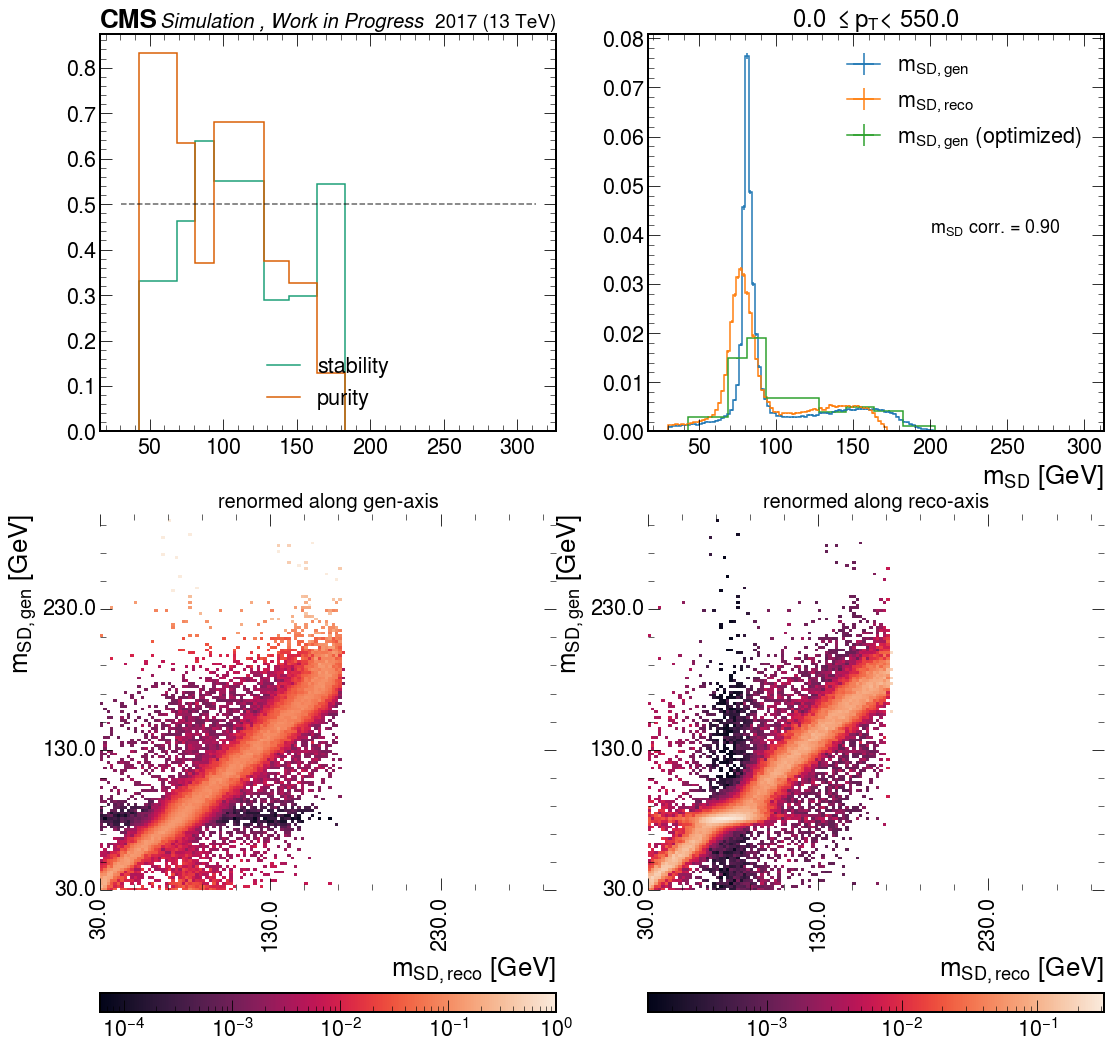

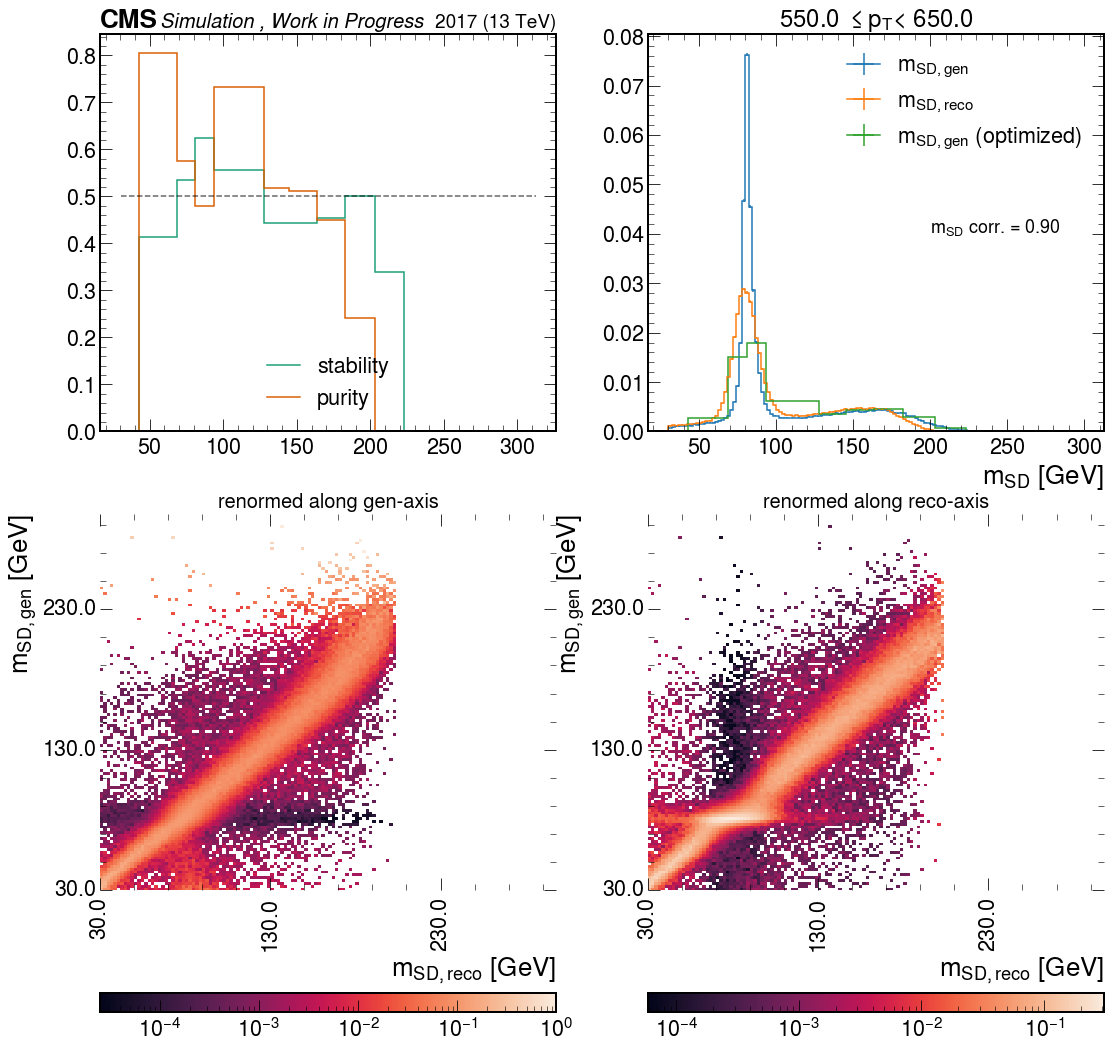

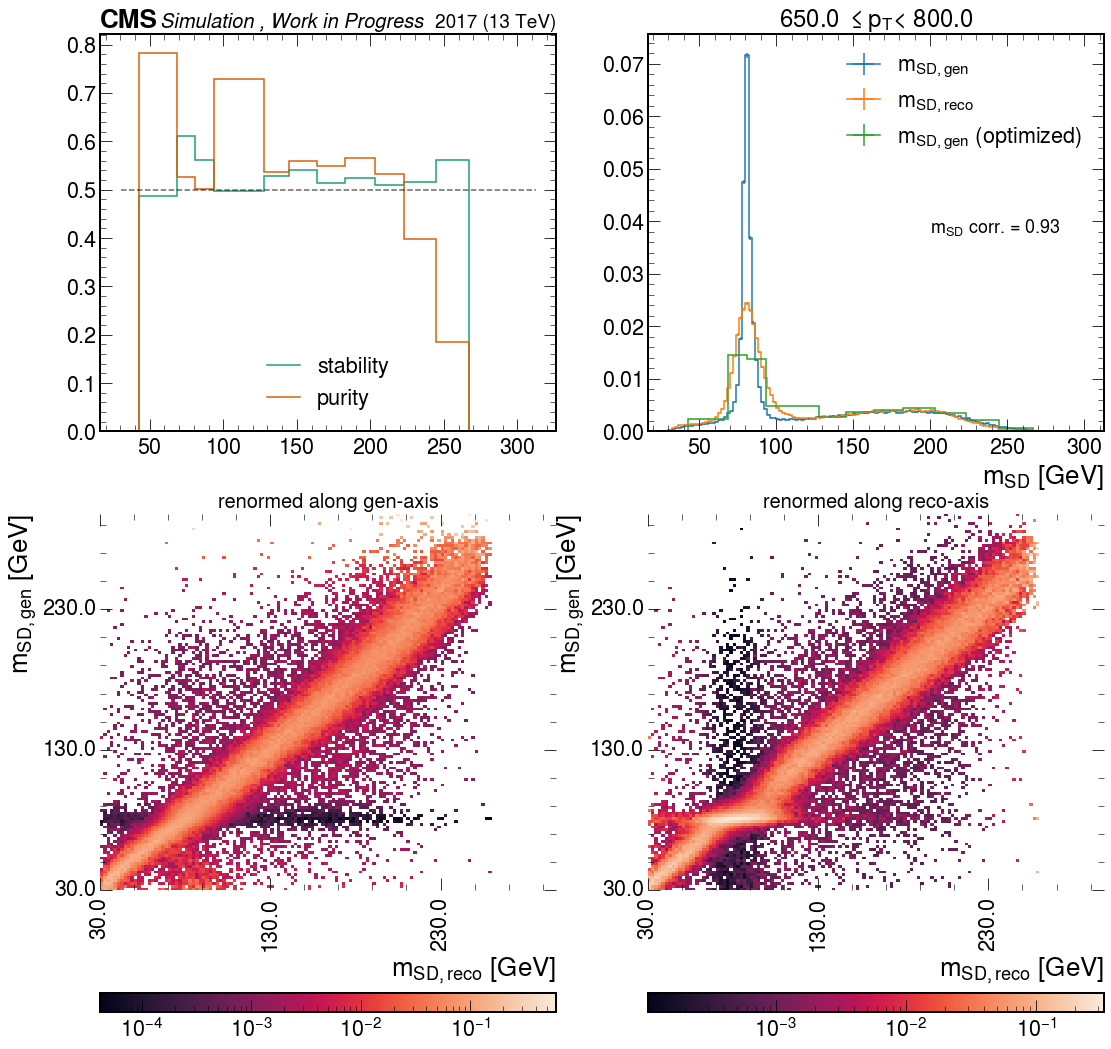

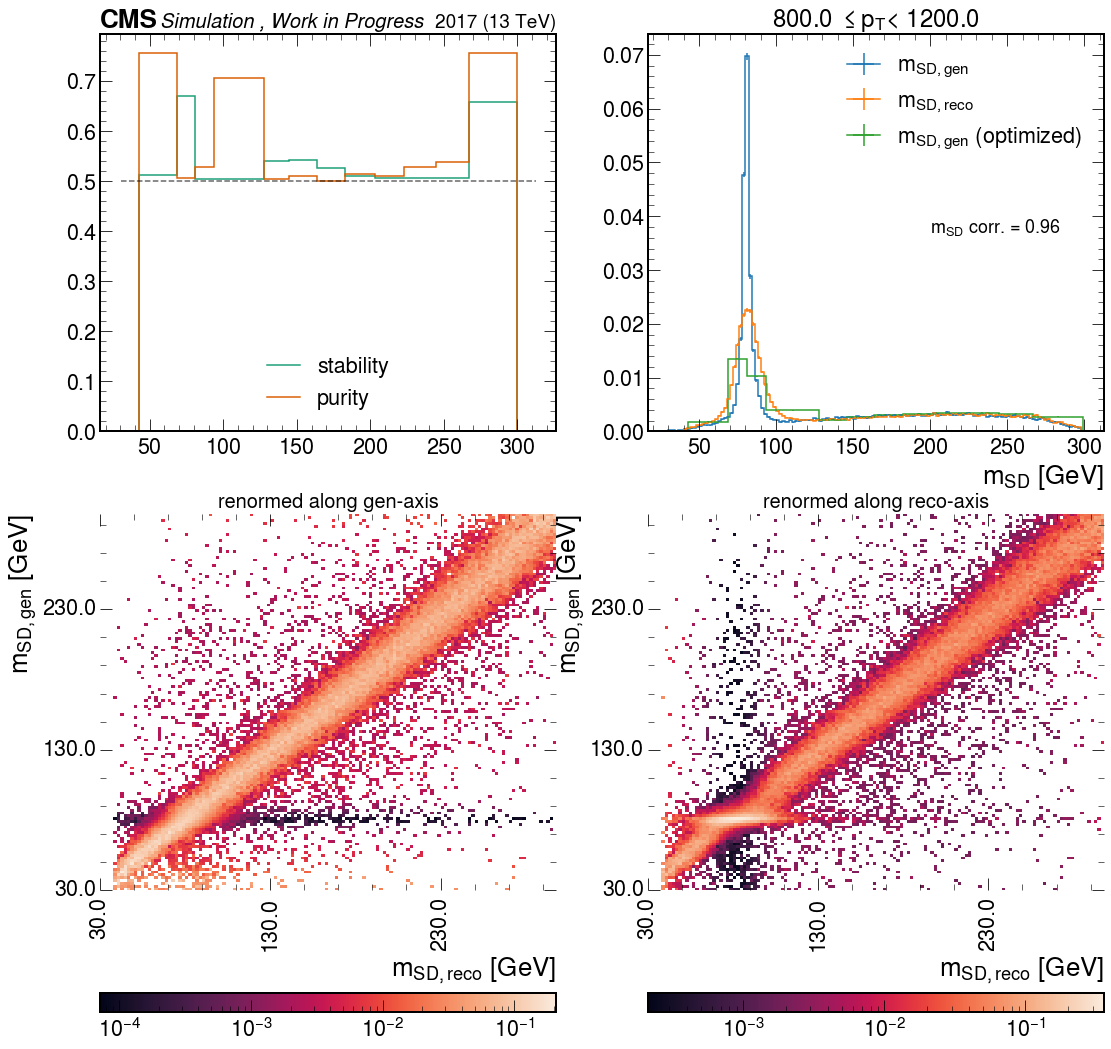

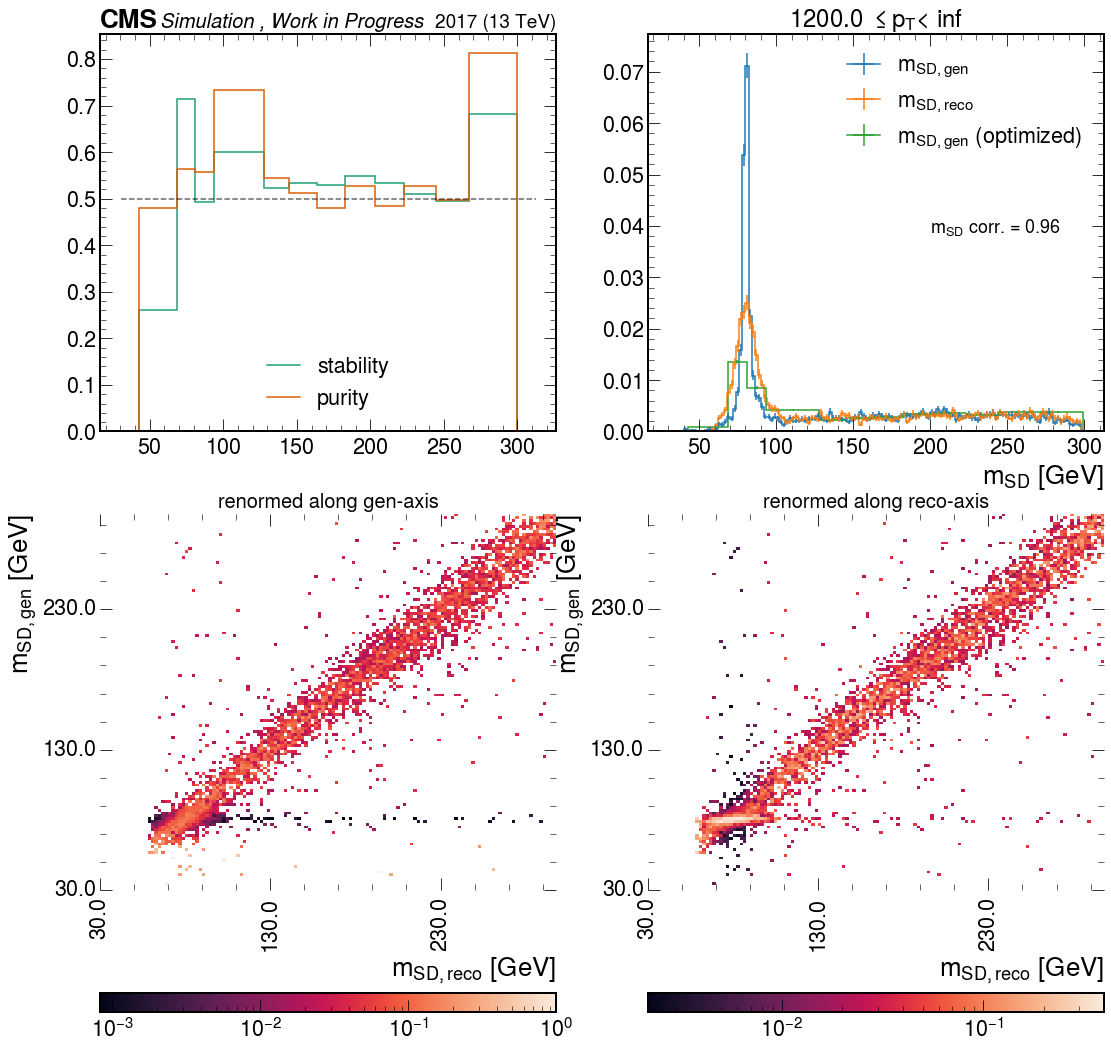

In [30]:
for ipt in range(len(pt_gen_binning)-1):
#for ipt in [2]:
    #select events from current pT bin
    pt_low = pt_gen_binning[ipt]
    pt_high = pt_gen_binning[ipt+1]
    events_pt_bin = events_sel[
        (events_sel.pt>= pt_low)
        &(events_sel.pt<pt_high)
                       ]
    f = make_optimization_plots(semifinal_mjet_binning,events_pt_bin,mjet_correction_factor=mjet_correction_factors[ipt],flow=False)
    f.savefig(f'unfolding_binning_plots/semifinal_binning_optimization_plots_ptbin_{str(pt_low).replace(".0","")}to{str(pt_high).replace(".0","")}.pdf')#,bbox_inches="tight")
    #optimize_and_plot(events_pt_bin,mjet_correction_factor=mjet_correction_factors[ipt],optimizer = bidirect_optimizer)
    #make_optimization_plots(events_pt_bin,mjet_correction_factor=mjet_correction_factors[ipt])